# _Let's Try Machine Learning_

In [1]:
# Phase 1 — Data Quality & Feature Sanity Checks (PM2.5 project)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
np.random.seed(SEED)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

In [2]:
DATA_PATH = "dataset_feature1.csv"
df = pd.read_csv(DATA_PATH)

# Phase 1

In [7]:
# 0) Imports and context
from IPython.display import display  # pretty printing in Jupyter
import pandas as pd

assert 'df' in globals(), "Expected a DataFrame named df in memory."
print("df shape:", df.shape)

df shape: (102720, 144)


In [8]:
# 1) Compute percent missing per column
miss = df.isna().mean().sort_values(ascending=False)
print("Computed column-wise missingness (fraction). Top 10 shown below.")
display(miss.head(10))

Computed column-wise missingness (fraction). Top 10 shown below.


PM2.5_lag24         0.004673
t2m_lag24           0.004673
rh_lag24            0.004673
wind_speed_lag24    0.004673
TOTEXTTAU_lag24     0.004673
mean_TIR1_lag24     0.004673
wind_speed_lag3     0.000584
rh_lag3             0.000584
TOTEXTTAU_lag3      0.000584
mean_TIR1_lag3      0.000584
dtype: float64

In [9]:
# 2) Inspect the top 30 missing columns
print("Top 30 columns by missingness:")
display(miss.head(30))

Top 30 columns by missingness:


PM2.5_lag24                 0.004673
t2m_lag24                   0.004673
rh_lag24                    0.004673
wind_speed_lag24            0.004673
TOTEXTTAU_lag24             0.004673
mean_TIR1_lag24             0.004673
wind_speed_lag3             0.000584
rh_lag3                     0.000584
TOTEXTTAU_lag3              0.000584
mean_TIR1_lag3              0.000584
t2m_lag3                    0.000584
PM2.5_lag3                  0.000584
rh_rolling24_std            0.000195
wind_speed_rolling24_std    0.000195
wind_speed_lag1             0.000195
t2m_lag1                    0.000195
TOTEXTTAU_rolling24_std     0.000195
rh_lag1                     0.000195
prev_ts                     0.000195
next_ts                     0.000195
mean_TIR1_rolling24_std     0.000195
PM2.5_lag1                  0.000195
mean_TIR1_lag1              0.000195
TOTEXTTAU_lag1              0.000195
PM2.5_rolling3_std          0.000195
t2m_rolling3_std            0.000195
wind_speed_rolling3_std     0.000195
r

In [10]:
# 3) Set threshold and domain whitelist
MISSINGNESS_DROP_THRESHOLD = 0.40  # 40%
DOMAIN_WHITELIST = set([
    # Example: "TOTEXTTAU", "mean_TIR1"  # keep if needed for satellite ablations
])

print(f"Threshold set at {int(MISSINGNESS_DROP_THRESHOLD*100)}% and whitelist has {len(DOMAIN_WHITELIST)} items.")

Threshold set at 40% and whitelist has 0 items.


In [11]:
# 4) Compute candidate drop list (not applied yet)
high_missing = miss[miss > MISSINGNESS_DROP_THRESHOLD].index.tolist()
to_drop = [c for c in high_missing if c not in DOMAIN_WHITELIST]

print(f"Columns over threshold: {len(high_missing)}")
print(f"Proposed drop (excluding whitelist): {len(to_drop)}")
print(to_drop[:30])  # preview first 30 names

Columns over threshold: 0
Proposed drop (excluding whitelist): 0
[]


In [12]:
# 5) Export the full missingness report (optional)
miss_df = miss.rename("missing_frac").to_frame()
miss_df.to_csv("phase1_missingness_report.csv", index=True)
print("Saved: phase1_missingness_report.csv")

Saved: phase1_missingness_report.csv


In [14]:
# 6) Optional: apply the drops AFTER review
# df = df.drop(columns=to_drop)
# print("After drop, df shape:", df.shape)

In [30]:
# merge back safely
df = df.merge(
    cov[["station_id", "coverage_pct"]],
    on="station_id",
    how="left",
    suffixes=("", "_calc")  # prevent _x/_y surprises
)

# if coverage_pct already existed in df, prefer the new one
if "coverage_pct_calc" in df.columns:
    df["coverage_pct"] = df["coverage_pct_calc"]
    df.drop(columns=["coverage_pct_calc"], inplace=True)

# classify
df["station_quality"] = pd.cut(
    df["coverage_pct"],
    bins=[-1, 0.7, 0.9, 1.1],
    labels=["poor", "medium", "good"]
)

print(
    df[["station_id","station_quality"]]
      .drop_duplicates()["station_quality"]
      .value_counts(dropna=False)
)

station_quality
medium    11
good       9
poor       0
Name: count, dtype: int64


In [28]:
# sid = df["station_id"].unique()[0]  # pick first station
# g = df[df["station_id"] == sid].sort_values("timestamp_utc")

# # Look at actual intervals
# print("First 20 timestamps:")
# print(g["timestamp_utc"].head(20))

# print("\nStep size distribution (hours):")
# print((g["timestamp_utc"].diff().dt.total_seconds()/3600).value_counts().head(10))

In [16]:
# Range clipping to avoid unstable ratios or invalid values
if "blh" in df.columns:
    df["blh"] = df["blh"].clip(lower=1.0)
if "wind_speed" in df.columns:
    df["wind_speed"] = df["wind_speed"].clip(lower=0)
if "wind_dir" in df.columns:
    df["wind_dir"] = df["wind_dir"] % 360

print("Applied basic clipping/normalization where columns exist (blh, wind_speed, wind_dir).")

Applied basic clipping/normalization where columns exist (blh, wind_speed, wind_dir).


In [31]:
# # Skewness and log1p helper for PM2.5
# import numpy as np
# import matplotlib.pyplot as plt

# skew_val = df["PM2.5"].dropna().skew()
# print("PM2.5 skew:", skew_val)
# df["PM25_log1p"] = np.log1p(df["PM2.5"])

# _ = df["PM2.5"].hist(bins=200)
# plt.title("PM2.5 distribution")
# plt.show()

# _ = df["PM25_log1p"].hist(bins=200)
# plt.title("log1p(PM2.5) distribution")
# plt.show()

In [32]:
# # Missingness heatmap for a quick station×time visual check
# import seaborn as sns
# import matplotlib.pyplot as plt

# sample_stations = df["station_id"].dropna().unique()[:20]
# dff = (df[df["station_id"].isin(sample_stations)]
#        .assign(miss_pm25=lambda x: x["PM2.5"].isna().astype(int)))

# pivot = (dff.pivot_table(index="station_id",
#                          columns="timestamp_utc",
#                          values="miss_pm25",
#                          aggfunc="max")
#          .fillna(1))  # 1 = missing

# plt.figure(figsize=(14, 6))
# sns.heatmap(pivot, cmap="viridis", cbar=False)
# plt.title("Missingness heatmap (PM2.5) for sampled stations")
# plt.tight_layout()
# plt.show()
# plt.savefig("Missingness heatmap (PM2.5).png", dpi=300, bbox_inches='tight')

# Finalising Phase 1

In [33]:
# 1) Station filter and ordered categorical encoding
import pandas as pd
from pandas.api.types import CategoricalDtype

# Keep good+medium for global experiments; retain coverage_pct as numeric feature
keep_mask = df["station_quality"].isin(["good", "medium"])
df_phase1 = df.loc[keep_mask].copy()

# Ordered categorical so models (or encoders) can map consistently
qual_type = CategoricalDtype(categories=["poor", "medium", "good"], ordered=True)
df_phase1["station_quality"] = df_phase1["station_quality"].astype(qual_type)

print("Kept rows:", df_phase1.shape, "Quality counts:")
print(df_phase1[["station_id","station_quality"]].drop_duplicates()["station_quality"].value_counts(dropna=False))

Kept rows: (102720, 149) Quality counts:
station_quality
medium    11
good       9
poor       0
Name: count, dtype: int64


In [34]:
# 2) Target config based on skew (train later with this flag)
import numpy as np

USE_LOG_TARGET = True   # default based on earlier skew review
df_phase1["PM25_log1p"] = np.log1p(df_phase1["PM2.5"])
print("USE_LOG_TARGET:", USE_LOG_TARGET, "| PM25_log1p added.")

USE_LOG_TARGET: True | PM25_log1p added.


In [35]:
# 3) Feature hygiene for downstream steps (no object columns except categories)
# Keep station id only for grouping (e.g., LOSO) and not as a model feature by default
non_feature_cols = {
    "timestamp_utc", "station_id", "PM2.5", "PM25_log1p"  # targets/ids/time
}
num_cols = df_phase1.select_dtypes(include=["number"]).columns.tolist()
cat_cols = df_phase1.select_dtypes(include=["category"]).columns.tolist()

feature_cols = [c for c in num_cols if c not in {"PM2.5"}] + cat_cols
print("Numeric features:", len([c for c in feature_cols if c in num_cols]),
      "| Categorical features:", len([c for c in feature_cols if c in cat_cols]))

Numeric features: 135 | Categorical features: 1


In [36]:
# 4) Persist a clean Phase 1 snapshot (parquet preserves dtypes incl. categorical)
OUT_PATH = "dataset_feature1_phase1_clean.parquet"
df_phase1.to_parquet(OUT_PATH, index=False)  # requires pyarrow or fastparquet installed
print("Saved Phase 1 snapshot:", OUT_PATH)

Saved Phase 1 snapshot: dataset_feature1_phase1_clean.parquet


# Phase 1 summary

# _Phase 1 END_

# Phase 2 start

In [39]:
## Phase 2 setup
# 0) Load Phase 1 snapshot and prepare columns
import json
import numpy as np
import pandas as pd

IN_PATH = "dataset_feature1_phase1_clean.parquet"
dfp = pd.read_parquet(IN_PATH)

TARGET_COL = "PM25_log1p"  # from Phase 1
ID_COLS = ["timestamp_utc", "station_id"]
AUX_EXCLUDE = [TARGET_COL, "PM2.5"]  # exclude raw target from features

# Include numeric features; add an ordinal code for station_quality for analysis only
if "station_quality" in dfp.columns and str(dfp["station_quality"].dtype) == "category":
    dfp["station_quality_code"] = dfp["station_quality"].cat.codes  # -1 if NaN, else ordered 0/1/2

num_feats_all = dfp.select_dtypes(include=["number"]).columns.tolist()
feature_pool = [c for c in num_feats_all if c not in set(ID_COLS + AUX_EXCLUDE)]

print("Rows, Cols:", dfp.shape)
print("Initial numeric feature count:", len(feature_pool))

Rows, Cols: (102720, 150)
Initial numeric feature count: 135


##  Correlation screening

In [40]:
# 1) Correlation matrix and feature–target correlation
CORR_THRESH = 0.85

# Feature-feature correlation
corr = dfp[feature_pool].corr(method="pearson", numeric_only=True)

# Pairs above threshold
upper = corr.where(np.triu(np.ones_like(corr, dtype=bool), k=1))
high_pairs = (upper.stack().rename("r").reset_index()
                 .rename(columns={"level_0":"f1","level_1":"f2"}))
high_pairs = high_pairs[high_pairs["r"].abs() > CORR_THRESH].sort_values("r", ascending=False)
print("High-correlation pairs (|r| >", CORR_THRESH, "):", high_pairs.shape)
display(high_pairs.head(20))

# Feature-target correlation for representative selection
ft_corr = dfp[feature_pool + [TARGET_COL]].corr(numeric_only=True)[TARGET_COL].drop(index=TARGET_COL)
ft_corr_abs = ft_corr.abs().sort_values(ascending=False)
display(ft_corr_abs.head(20))

High-correlation pairs (|r| > 0.85 ): (156, 3)


,f1,f2,r
8253,coverage_pct_y,coverage_pct,1.000000
6126,hour_utc,hour,1.000000
5118,wind_dir,wind_dir_rad,1.000000
8251,coverage_pct_x,coverage_pct,0.999999
8250,coverage_pct_x,coverage_pct_y,0.999999
45,latitude,grid_latitude,0.999941
3306,p90_WV,p95_WV,0.999843
2904,max_WV,p95_WV,0.999840
2588,mean_WV,median_WV,0.999542
2903,max_WV,p90_WV,0.999365


PM2.5_rolling3_mean     0.810503
PM2.5_lag1              0.753860
PM2.5_rolling24_mean    0.737273
PM2.5_lag3              0.634102
PM2.5_lag24             0.572102
BCEXTTAU                0.532625
PM2.5_rolling24_std     0.516908
t2m_rolling24_std       0.513513
d2m_rolling24           0.510616
d2m_rolling3            0.503030
d2m_lag1                0.501006
d2m                     0.492503
PM2.5_rolling3_std      0.457585
doy_cos                 0.444253
latitude                0.420332
grid_latitude           0.420137
rh_rolling24_std        0.418093
OCEXTTAU                0.404837
img_max                 0.391775
sp                      0.368568
Name: PM25_log1p, dtype: float64

In [42]:
# 2) Build correlation clusters and select representatives by strongest |corr with target|

# Simple union-find to cluster features that are pairwise above threshold
parent = {}
def find(x):
    parent.setdefault(x, x)
    if parent[x] != x:
        parent[x] = find(parent[x])
    return parent[x]

def union(a, b):
    ra, rb = find(a), find(b)
    if ra != rb:
        parent[rb] = ra

# Build unions from high correlation pairs
for _, row in high_pairs.iterrows():
    union(row["f1"], row["f2"])

# Assign groups; singletons (no high corr) form their own groups
groups = {}
for f in feature_pool:
    r = find(f) if f in parent else f
    groups.setdefault(r, []).append(f)

# Pick representative per group as feature with highest |corr(target)|
rep_features = []
dropped_by_corr = []

for root, members in groups.items():
    if len(members) == 1:
        # FIX: take the string, not the list
        rep_features.append(members[0])
    else:
        best = max(members, key=lambda m: ft_corr_abs.get(m, 0.0))
        rep_features.append(best)
        dropped_by_corr.extend([m for m in members if m != best])

# Deduplicate and sort
rep_features = sorted(set(rep_features))

print("Representative features kept:", len(rep_features))
print("Dropped by correlation grouping:", len(dropped_by_corr))

Representative features kept: 73
Dropped by correlation grouping: 62


## VIF pruning

In [44]:
# 3) VIF computation with iterative pruning
import statsmodels.api as sm
import numpy as np
import pandas as pd

def compute_vif_series(df_num: pd.DataFrame) -> pd.Series:
    X = df_num.copy()
    # Median fill for OLS stability; upstream time-aware imputations remain separate
    X = X.fillna(X.median(numeric_only=True))
    vif_vals = {}
    X_mat = sm.add_constant(X.values, has_constant="add")
    for i, col in enumerate(X.columns):
        y = X.iloc[:, i].values
        X_other = np.delete(X_mat, i+1, axis=1)  # remove the i-th feature column (offset by const)
        try:
            r2 = sm.OLS(y, X_other).fit().rsquared
        except Exception:
            r2 = 0.0
        vif_vals[col] = np.inf if (1 - r2) == 0 else 1.0 / (1.0 - r2)
    return pd.Series(vif_vals).sort_values(ascending=False)

# Threshold for multicollinearity
VIF_THRESH = 10.0
features_vif = rep_features.copy()
max_iters = 50
dropped_by_vif = []

for it in range(max_iters):
    vif_series = compute_vif_series(dfp[features_vif])

    worst_feat = vif_series.index[0]      # FIX: take the top feature name
    worst_val = float(vif_series.iloc[0]) # FIX: take its scalar value

    print(f"Iter {it}: top VIF {worst_feat} = {worst_val:.2f}")

    if worst_val <= VIF_THRESH or len(features_vif) <= 2:
        break

    # Drop the worst offender and continue
    features_vif.remove(worst_feat)
    dropped_by_vif.append((worst_feat, worst_val))

print("Final feature count after VIF pruning:", len(features_vif))
print("Dropped by VIF:", dropped_by_vif)

display(vif_series.head(20))

D:\Anaconda\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
D:\Anaconda\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Iter 0: top VIF t2m_rolling3 = 32.19


D:\Anaconda\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
D:\Anaconda\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Iter 1: top VIF TOTEXTTAU_rolling3_mean = 15.39


D:\Anaconda\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
D:\Anaconda\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Iter 2: top VIF t2m_rolling24_std = 13.35


D:\Anaconda\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
D:\Anaconda\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Iter 3: top VIF rh_rolling24_mean = 11.48


D:\Anaconda\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
D:\Anaconda\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Iter 4: top VIF PM2.5_rolling24_mean = 9.84
Final feature count after VIF pruning: 69
Dropped by VIF: [('t2m_rolling3', 32.18943289296813), ('TOTEXTTAU_rolling3_mean', 15.390815174620736), ('t2m_rolling24_std', 13.353141537259841), ('rh_rolling24_mean', 11.478103188741928)]


PM2.5_rolling24_mean         9.844601
ssrd                         7.847540
rh_rolling3_mean             7.750731
wind_speed_rolling24         7.340462
inversion_strength           6.684743
doy_cos                      6.382842
d2m_rolling24                6.379276
latitude                     6.333228
TOTEXTTAU_rolling24_mean     5.804696
PM2.5_rolling3_mean          5.756918
wind_speed_rolling24_mean    5.696033
hour_cos                     5.485235
mean_TIR1_rolling24_mean     5.195000
doy_sin                      5.111310
sp                           4.908949
min_WV                       4.685503
BCEXTTAU                     4.379020
wind_speed_lag3              4.006958
hour_sin                     3.865061
img_std                      3.864447
dtype: float64

## Outputs and saves

In [45]:
# 4) Persist selections for modeling
summary = {
    "n_features_start": len(feature_pool),
    "n_features_after_corr": len(rep_features),
    "n_features_after_vif": len(features_vif),
    "corr_threshold": CORR_THRESH,
    "vif_threshold": VIF_THRESH,
    "dropped_by_corr_count": len(dropped_by_corr),
    "dropped_by_vif_count": len(dropped_by_vif),
}
print(summary)

with open("features_phase2_selected.json", "w") as f:
    json.dump({
        "selected_features": features_vif,
        "dropped_by_corr": dropped_by_corr,
        "dropped_by_vif": dropped_by_vif,
        "params": {"corr_threshold": CORR_THRESH, "vif_threshold": VIF_THRESH}
    }, f, indent=2)

pd.Series(features_vif, name="feature").to_csv("features_phase2_selected.csv", index=False)
print("Saved: features_phase2_selected.json and features_phase2_selected.csv")

{'n_features_start': 135, 'n_features_after_corr': 73, 'n_features_after_vif': 69, 'corr_threshold': 0.85, 'vif_threshold': 10.0, 'dropped_by_corr_count': 62, 'dropped_by_vif_count': 4}
Saved: features_phase2_selected.json and features_phase2_selected.csv


# baseline XGBoost with TimeSeriesSplit using the 69 selected features and the log1p target

In [49]:
## Code: Baseline with TimeSeriesSplit
# Load selections and train baseline with time-aware CV on log1p target
import json
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

SEED = 42
USE_LOG_TARGET = True

# Load data and feature list
dfp = pd.read_parquet("dataset_feature1_phase1_clean.parquet")
with open("features_phase2_selected.json","r") as f:
    sel = json.load(f)
features = sel.get("selected_features", [])

# Keep only features that actually exist in dataframe (prevents KeyError)
features = [f for f in features if f in dfp.columns]
if not features:
    raise ValueError("No valid features found in dataset based on selected_features.json")

X = dfp[features]
y = dfp["PM25_log1p"] if USE_LOG_TARGET else dfp["PM2.5"]

def inv_if_log(a):
    return np.expm1(a) if USE_LOG_TARGET else a

model = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=SEED,
    n_jobs=-1,
    tree_method="hist",
)

tss = TimeSeriesSplit(n_splits=5)
folds = []
for k, (tr, va) in enumerate(tss.split(X)):
    model.fit(X.iloc[tr], y.iloc[tr])
    pred = model.predict(X.iloc[va])

    y_true = inv_if_log(y.iloc[va])
    y_pred = inv_if_log(pred)

    # <<-- FIX: compute RMSE via sqrt(MSE) for compatibility
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    r2 = r2_score(y_true, y_pred)
    folds.append({"fold": k+1, "rmse": rmse, "r2": r2})

print(pd.DataFrame(folds))

   fold       rmse        r2
0     1  18.477854  0.956578
1     2  22.518207  0.875773
2     3  17.361687  0.733573
3     4  23.805029  0.653551
4     5  19.947946  0.800552


In [51]:
# Code: Permutation importance on last fold
# Compute permutation importance on the last validation fold for interpretability
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance

# Get train/validation indices for the last fold
last_tr_idx, last_va_idx = list(tss.split(X))[-1]

# Refit model on training part of the last fold
model.fit(X.iloc[last_tr_idx], y.iloc[last_tr_idx])

# Permutation importance on the validation fold
r = permutation_importance(
    model,
    X.iloc[last_va_idx],
    y.iloc[last_va_idx],
    n_repeats=20,
    random_state=SEED,
    n_jobs=-1,
    scoring="r2"
)

# Collect feature importances
imp = pd.Series(r.importances_mean, index=features).sort_values(ascending=False)
print(imp.head(20))

PM2.5_rolling3_mean          1.899204
PM2.5_rolling3_std           0.073058
PM2.5_lag3                   0.039373
PM2.5_rolling24_mean         0.008671
PM2.5_rolling24_std          0.005618
stability                    0.004838
tp_rolling24                 0.004388
tp_rolling3                  0.003126
t2m_rolling3_std             0.002886
blh                          0.002515
ssrd                         0.002368
wind_speed_lag3              0.001860
gap_from_prev_h              0.001809
hour_cos                     0.001561
wind_speed_rolling24         0.001253
rh_rolling3_mean             0.000920
BCEXTTAU                     0.000790
PM2.5_lag24                  0.000710
wind_speed_rolling24_mean    0.000686
rh_rolling24_std             0.000625
dtype: float64


In [53]:
# Code: Permutation importance on last fold
# Compute permutation importance on the last validation fold for interpretability
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance

# Get the last fold (train indices, validation indices)
last_tr_idx, last_va_idx = list(tss.split(X))[-1]

# Train model on training part of last fold
model.fit(X.iloc[last_tr_idx], y.iloc[last_tr_idx])

# Run permutation importance on validation part of last fold
r = permutation_importance(
    model,
    X.iloc[last_va_idx],
    y.iloc[last_va_idx],
    n_repeats=20,
    random_state=SEED,
    n_jobs=-1,
    scoring="r2"
)

# Collect importances as a sorted Series
imp = pd.Series(r.importances_mean, index=features).sort_values(ascending=False)

# Show top 20 important features
print(imp.head(20))

PM2.5_rolling3_mean          1.899204
PM2.5_rolling3_std           0.073058
PM2.5_lag3                   0.039373
PM2.5_rolling24_mean         0.008671
PM2.5_rolling24_std          0.005618
stability                    0.004838
tp_rolling24                 0.004388
tp_rolling3                  0.003126
t2m_rolling3_std             0.002886
blh                          0.002515
ssrd                         0.002368
wind_speed_lag3              0.001860
gap_from_prev_h              0.001809
hour_cos                     0.001561
wind_speed_rolling24         0.001253
rh_rolling3_mean             0.000920
BCEXTTAU                     0.000790
PM2.5_lag24                  0.000710
wind_speed_rolling24_mean    0.000686
rh_rolling24_std             0.000625
dtype: float64


In [55]:
# Code: LOSO (GroupKFold by station)
# Leave-One-Station-Out evaluation (outer loop)
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, r2_score

SEED = 42

# Define inverse-transform helper
def inv_if_log(a): 
    return np.expm1(a) if USE_LOG_TARGET else a

groups = dfp["station_id"].values
n_splits = min(5, dfp["station_id"].nunique())  # safety: max folds = num stations
gkf = GroupKFold(n_splits=n_splits)

outer = []
for k, (tr, te) in enumerate(gkf.split(X, y, groups=groups), start=1):
    m = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=SEED,
        n_jobs=-1,
        tree_method="hist"
    )
    # Fit on training fold
    m.fit(X.iloc[tr], y.iloc[tr])

    # Predict on test fold
    p = m.predict(X.iloc[te])

    # Compute RMSE (manual sqrt to avoid 'squared' argument issue)
    y_true = inv_if_log(y.iloc[te])
    y_pred = inv_if_log(p)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    outer.append({"station_fold": k, "rmse": rmse, "r2": r2})

# Collect results in a DataFrame for readability
outer_df = pd.DataFrame(outer)
print(outer_df)

   station_fold       rmse        r2
0             1  22.916770  0.914191
1             2  26.268783  0.871111
2             3  18.899449  0.925205
3             4  16.384506  0.828002
4             5  16.444480  0.934302


# Leakage audit for PM2.5 rollings

In [56]:
# Audit: do PM2.5 rolling features inadvertently include the current target?
import numpy as np
import pandas as pd

pm_cols = [c for c in X.columns if c.startswith("PM2.5_rolling") or c.startswith("PM2.5_lag")]
check_cols = [c for c in pm_cols if "rolling" in c]

def leakage_probe(df, target="PM2.5", cols=None, tol=1e-6):
    out = []
    for c in cols or []:
        s = df[c] - df[target]
        near_equal = np.isfinite(s) & (s.abs() < tol)
        out.append((c, int(near_equal.sum()), float(near_equal.mean())))
    return pd.DataFrame(out, columns=["feature","n_near_equal","frac_near_equal"])

probe = leakage_probe(dfp, target="PM2.5", cols=check_cols)
display(probe.sort_values("frac_near_equal", ascending=False).head(10))

# Recompute SAFE past-only rollings if any suspicious near-equality is found
def past_only_rollings(dfin, group_col="station_id", target="PM2.5"):
    df2 = dfin.copy()
    g = df2.sort_values(["station_id","timestamp_utc"]).groupby(group_col)
    # Example for 3h and 24h means/stds using past-only windows:
    df2["PM25_past_rolling3_mean"] = g[target].shift(1).rolling(3, min_periods=1).mean()
    df2["PM25_past_rolling3_std"]  = g[target].shift(1).rolling(3, min_periods=2).std()
    df2["PM25_past_rolling24_mean"] = g[target].shift(1).rolling(24, min_periods=1).mean()
    df2["PM25_past_rolling24_std"]  = g[target].shift(1).rolling(24, min_periods=2).std()
    return df2

# If probe shows high near-equality, run:
# dfp = past_only_rollings(dfp)
# Update feature set by replacing old rolling names with new *_past_* names if used.

,feature,n_near_equal,frac_near_equal
2,PM2.5_rolling3_mean,719,0.007000
0,PM2.5_rolling24_mean,72,0.000701
3,PM2.5_rolling3_std,2,0.000019
1,PM2.5_rolling24_std,0,0.000000


In [60]:
# Lightweight randomized search with time-aware CV (no early stopping)
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

SEED = 42
rng = np.random.RandomState(SEED)

param_space = {
    "n_estimators": [600, 800, 1200, 1600],
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [6, 8, 10],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_lambda": [0.0, 1.0, 5.0],
    "reg_alpha": [0.0, 0.5, 1.0],
}

def sample_params(space, n=20):
    keys = list(space.keys())
    for _ in range(n):
        yield {k: rng.choice(space[k]) for k in keys}

def inv_if_log(a):
    return np.expm1(a) if USE_LOG_TARGET else a

tss = TimeSeriesSplit(n_splits=5)
best = None

for params in sample_params(param_space, n=20):
    fold_scores = []
    for tr, va in tss.split(X):
        model = XGBRegressor(
            random_state=SEED,
            n_jobs=-1,
            tree_method="hist",
            **params
        )
        model.fit(X.iloc[tr], y.iloc[tr])  # simple fit, no eval_metric / early stopping
        pred = model.predict(X.iloc[va])
        rmse = np.sqrt(mean_squared_error(inv_if_log(y.iloc[va]), inv_if_log(pred)))
        r2 = r2_score(inv_if_log(y.iloc[va]), inv_if_log(pred))
        fold_scores.append((rmse, r2, params["n_estimators"]))

    avg_rmse = float(np.mean([s[0] for s in fold_scores]))
    avg_r2 = float(np.mean([s[1] for s in fold_scores]))
    cand = {"params": params, "avg_rmse": avg_rmse, "avg_r2": avg_r2, "folds": fold_scores}
    if (best is None) or (avg_rmse < best["avg_rmse"]):
        best = cand

print("Best (avg over folds):", best["avg_rmse"], best["avg_r2"])
print("Best params:", best["params"])

Best (avg over folds): 20.031865130107363 0.8121919423224908
Best params: {'n_estimators': np.int64(800), 'learning_rate': np.float64(0.03), 'max_depth': np.int64(8), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(0.8), 'reg_lambda': np.float64(1.0), 'reg_alpha': np.float64(0.0)}


In [61]:
# Define feature groups by name patterns (adjust to exact column names)
all_feats = features.copy()

history_feats = [c for c in all_feats if c.startswith("PM2.5_") or c.startswith("gap_") or c.endswith("_was_imputed")]
era5_feats = [c for c in all_feats if c.startswith(("t2m","d2m","rh","wind_speed","wind_dir","blh","sp","ssrd","tp","inversion_strength","stability","moisture_deficit"))]
sat_feats = [c for c in all_feats if c.startswith(("mean_TIR1","median_TIR1","max_TIR1","p","img_","WV","wind_dir_rad"))]
merra_feats = [c for c in all_feats if c.startswith(("TOTEXTTAU","OCEXTTAU","BCEXTTAU"))]

def cv_eval(feat_list, label):
    if len(feat_list) == 0: 
        return {"label": label, "rmse": np.nan, "r2": np.nan}
    rmse_list, r2_list = [], []
    for tr, va in TimeSeriesSplit(n_splits=5).split(X):
        m = XGBRegressor(
            n_estimators=best["params"]["n_estimators"] if "best" in globals() and best else 800,
            learning_rate=best["params"]["learning_rate"] if "best" in globals() and best else 0.05,
            max_depth=best["params"]["max_depth"] if "best" in globals() and best else 8,
            subsample=best["params"]["subsample"] if "best" in globals() and best else 0.8,
            colsample_bytree=best["params"]["colsample_bytree"] if "best" in globals() and best else 0.8,
            reg_lambda=best["params"]["reg_lambda"] if "best" in globals() and best else 1.0,
            reg_alpha=best["params"]["reg_alpha"] if "best" in globals() and best else 0.0,
            random_state=SEED, n_jobs=-1, tree_method="hist",
        )
        m.fit(X.iloc[tr][feat_list], y.iloc[tr])
        p = m.predict(X.iloc[va][feat_list])
        rmse = np.sqrt(mean_squared_error(inv_if_log(y.iloc[va]), inv_if_log(p)))
        r2 = r2_score(inv_if_log(y.iloc[va]), inv_if_log(p))
        rmse_list.append(rmse); r2_list.append(r2)
    return {"label": label, "rmse": float(np.mean(rmse_list)), "r2": float(np.mean(r2_list))}

ablation_results = []
ablation_results.append(cv_eval(history_feats, "History only"))
ablation_results.append(cv_eval(era5_feats, "ERA5 only"))
ablation_results.append(cv_eval(sat_feats, "Satellite only"))
ablation_results.append(cv_eval(merra_feats, "MERRA-2 only"))
ablation_results.append(cv_eval(all_feats, "Combined"))
pd.DataFrame(ablation_results)

,label,rmse,r2
0,History only,20.441365,0.810715
1,ERA5 only,45.326512,0.150207
2,Satellite only,54.480554,-0.244039
3,MERRA-2 only,49.751184,0.050665
4,Combined,20.031865,0.812192


Loaded 69 features from JSON.
Mapped 'station_quality_code' -> 'station_quality' because df contains 'station_quality'.
All JSON-selected features are present in dataframe.
Using 69 features after cleanup.
Converted 'station_quality' to integer codes for XGBoost.

Running TimeSeriesSplit CV with XGB baseline...
 Fold 1: rmse=18.6733, r2=0.9557
 Fold 2: rmse=22.4185, r2=0.8769
 Fold 3: rmse=17.5285, r2=0.7284
 Fold 4: rmse=24.2769, r2=0.6397
 Fold 5: rmse=19.6608, r2=0.8063

Fitted final model on last training fold.
SHAP: using background size 85,600 and explain set size 17,120


100%|===================| 17118/17120 [23:47<00:00]        


Top 20 features by mean(|SHAP value|):
PM2.5_rolling3_mean          0.590439
PM2.5_rolling3_std           0.060077
PM2.5_lag3                   0.044629
PM2.5_rolling24_mean         0.020951
stability                    0.018184
blh                          0.013594
img_std                      0.012545
BCEXTTAU                     0.011667
PM2.5_rolling24_std          0.010003
rh_rolling3_mean             0.009385
tp_rolling3                  0.009336
ssrd                         0.009026
latitude                     0.008994
d2m_rolling24                0.008442
rh_rolling24_std             0.008356
t2m_rolling3_std             0.008246
sp                           0.007947
tp_rolling24                 0.007161
longitude                    0.006345
wind_speed_rolling24_mean    0.006261
dtype: float64


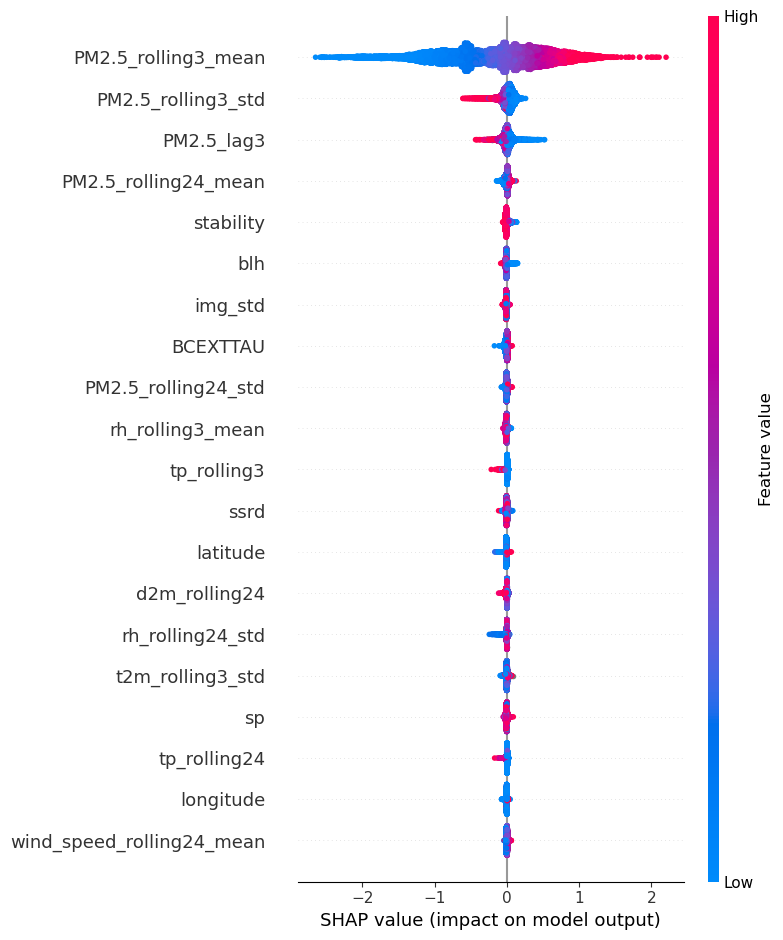


Done.


In [7]:
# Full pipeline with robust fix for "station_quality_code" KeyError
import json
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import shap

SEED = 42
USE_LOG_TARGET = True

# -------------------------------
# Load dataset and feature list
# -------------------------------
dfp = pd.read_parquet("dataset_feature1_phase1_clean.parquet")

with open("features_phase2_selected.json", "r") as f:
    sel = json.load(f)
features = sel.get("selected_features", [])
print(f"Loaded {len(features)} features from JSON.")

# -------------------------------
# Repair/align requested features to dfp columns
# -------------------------------
# 1) If JSON requested 'station_quality_code' but df has 'station_quality', map it.
features = list(features)  # ensure mutable list
mapped = False
for i, f in enumerate(features):
    if f == "station_quality_code" and "station_quality" in dfp.columns:
        features[i] = "station_quality"
        mapped = True
if mapped:
    print("Mapped 'station_quality_code' -> 'station_quality' because df contains 'station_quality'.")

# 2) Remove any features that are not present in dfp (safe guard)
missing = [f for f in features if f not in dfp.columns]
if missing:
    print(f"Warning: {len(missing)} features from JSON are missing in dataframe and will be dropped:")
    print(missing)
    features = [f for f in features if f in dfp.columns]
else:
    print("All JSON-selected features are present in dataframe.")

if len(features) == 0:
    raise ValueError("No valid features remain after aligning JSON with dataframe columns.")

# Deduplicate feature list and preserve order
seen = set()
features_final = []
for f in features:
    if f not in seen:
        seen.add(f)
        features_final.append(f)
features = features_final
print(f"Using {len(features)} features after cleanup.")

# -------------------------------
# Prepare X and y
# -------------------------------
X = dfp[features].copy()
y = dfp["PM25_log1p"] if USE_LOG_TARGET else dfp["PM2.5"]

# -------------------------------
# Convert categorical columns XGBoost can't consume (station_quality)
# -------------------------------
if "station_quality" in X.columns:
    # Convert to ordered integer codes (poor=0, medium=1, good=2) if string/category
    if not pd.api.types.is_integer_dtype(X["station_quality"]):
        X["station_quality"] = X["station_quality"].astype("category").cat.codes
        print("Converted 'station_quality' to integer codes for XGBoost.")

# If any other non-numeric columns remain, try to coerce or raise helpful error
non_numeric = [c for c in X.columns if not pd.api.types.is_numeric_dtype(X[c])]
if non_numeric:
    # Best effort: try converting object columns that look numeric
    for c in non_numeric:
        try:
            X[c] = pd.to_numeric(X[c])
        except Exception:
            pass
    # Re-check
    non_numeric = [c for c in X.columns if not pd.api.types.is_numeric_dtype(X[c])]
    if non_numeric:
        raise ValueError(f"The following features are non-numeric and cannot be used by XGBoost: {non_numeric}")

# -------------------------------
# Inverse log helper
# -------------------------------
def inv_if_log(a):
    return np.expm1(a) if USE_LOG_TARGET else a

# -------------------------------
# TimeSeriesSplit CV (baseline training)
# -------------------------------
tss = TimeSeriesSplit(n_splits=5)
folds = []
print("\nRunning TimeSeriesSplit CV with XGB baseline...")

for k, (tr, va) in enumerate(tss.split(X), start=1):
    model = XGBRegressor(
        n_estimators=800,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=SEED,
        n_jobs=-1,
        tree_method="hist"
    )
    model.fit(X.iloc[tr], y.iloc[tr])
    pred = model.predict(X.iloc[va])
    y_true = inv_if_log(y.iloc[va])
    y_pred = inv_if_log(pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    folds.append({"fold": k, "rmse": rmse, "r2": r2})
    print(f" Fold {k}: rmse={rmse:.4f}, r2={r2:.4f}")

# -------------------------------
# Fit final model on last training fold
# -------------------------------
tr_idx, va_idx = list(tss.split(X))[-1]
model_final = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=SEED,
    n_jobs=-1,
    tree_method="hist"
)
model_final.fit(X.iloc[tr_idx], y.iloc[tr_idx])
print("\nFitted final model on last training fold.")

# -------------------------------
# SHAP full-coverage explanation on last fold
# -------------------------------
X_tr = X.iloc[tr_idx]
X_va = X.iloc[va_idx]
print(f"SHAP: using background size {len(X_tr):,} and explain set size {len(X_va):,}")

# Use interventional mode (safe for XGBoost 3.x) with full validation as both background/explain
expl = shap.TreeExplainer(model_final, data=X_tr, feature_perturbation="interventional")
sv = expl.shap_values(X_va)

# Show top 20 features as a quick table
imp = pd.Series(np.abs(sv).mean(axis=0), index=X_va.columns).sort_values(ascending=False)
print("\nTop 20 features by mean(|SHAP value|):")
print(imp.head(20))

# Optionally plot (comment out if running headless)
try:
    shap.summary_plot(sv, X_va, show=True)
except Exception as e:
    print("SHAP plotting failed (maybe headless). Exception:", e)

print("\nDone.")


# Recompute past‑only rollings

In [8]:
# Recompute PM2.5 rollings using strictly past data (shift(1) → rolling)
import pandas as pd

def recompute_past_rollings(dfin, group_col="station_id", time_col="timestamp_utc", target="PM2.5"):
    df2 = dfin.sort_values([group_col, time_col]).copy()
    g = df2.groupby(group_col, group_keys=False)[target]
    df2["PM25_past_rolling3_mean"]  = g.shift(1).rolling(3,  min_periods=1).mean()
    df2["PM25_past_rolling3_std"]   = g.shift(1).rolling(3,  min_periods=2).std()
    df2["PM25_past_rolling24_mean"] = g.shift(1).rolling(24, min_periods=1).mean()
    df2["PM25_past_rolling24_std"]  = g.shift(1).rolling(24, min_periods=2).std()
    return df2

dfp_safe = recompute_past_rollings(dfp)

In [9]:
# Replace original rolling columns with the past-only versions in the feature list
replace_map = {
    "PM2.5_rolling3_mean": "PM25_past_rolling3_mean",
    "PM2.5_rolling3_std": "PM25_past_rolling3_std",
    "PM2.5_rolling24_mean": "PM25_past_rolling24_mean",
    "PM2.5_rolling24_std": "PM25_past_rolling24_std",
}
features_safe = [replace_map.get(f, f) for f in features]
print("Using", len(features_safe), "features with past-only PM2.5 rollings")

Using 69 features with past-only PM2.5 rollings


# TimeSeriesSplit with a small temporal gap

In [11]:
# Re-run TSS with small gap and categorical fix
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

USE_LOG_TARGET = True

X2 = dfp_safe[features_safe].copy()
y2 = dfp_safe["PM25_log1p"] if USE_LOG_TARGET else dfp_safe["PM2.5"]

# -------------------------------
# Convert categorical columns to numeric codes
# -------------------------------
for c in X2.select_dtypes(include="category").columns:
    X2[c] = X2[c].cat.codes
    print(f"Converted categorical '{c}' to integer codes.")

# -------------------------------
# Inverse log helper
# -------------------------------
def inv_if_log(a):
    return np.expm1(a) if USE_LOG_TARGET else a

# -------------------------------
# Model parameters
# -------------------------------
best_params = {
    'n_estimators': 800,
    'learning_rate': 0.03,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1.0,
    'reg_alpha': 0.0
}

# -------------------------------
# TimeSeriesSplit with gap
# -------------------------------
tss_gap = TimeSeriesSplit(n_splits=5, gap=3)  # 3-hour gap

folds = []
for k, (tr, va) in enumerate(tss_gap.split(X2), start=1):
    m = XGBRegressor(random_state=42, n_jobs=-1, tree_method="hist", **best_params)
    m.fit(X2.iloc[tr], y2.iloc[tr])
    p = m.predict(X2.iloc[va])
    rmse = np.sqrt(mean_squared_error(inv_if_log(y2.iloc[va]), inv_if_log(p)))
    r2 = r2_score(inv_if_log(y2.iloc[va]), inv_if_log(p))
    folds.append({"fold": k, "rmse": rmse, "r2": r2})
    print(f" Fold {k}: rmse={rmse:.4f}, r2={r2:.4f}")

folds_df = pd.DataFrame(folds)
print("\nAll folds:")
print(folds_df)

Converted categorical 'station_quality' to integer codes.
 Fold 1: rmse=32.7841, r2=0.8633
 Fold 2: rmse=35.2302, r2=0.6959
 Fold 3: rmse=23.1154, r2=0.5277
 Fold 4: rmse=32.4694, r2=0.3555
 Fold 5: rmse=26.6402, r2=0.6443

All folds:
   fold       rmse        r2
0     1  32.784099  0.863312
1     2  35.230240  0.695926
2     3  23.115448  0.527721
3     4  32.469407  0.355458
4     5  26.640230  0.644280


In [12]:
# Evaluate combined model without any PM2.5 history features
history_prefixes = ("PM2.5_", "PM25_", "gap_")
non_history_feats = [f for f in features_safe if not f.startswith(history_prefixes)]

def cv_eval(feat_list, label):
    if not feat_list:
        return {"label": label, "rmse": np.nan, "r2": np.nan}
    rmse_list, r2_list = [], []
    for tr, va in TimeSeriesSplit(n_splits=5, gap=3).split(X2):
        m = XGBRegressor(random_state=42, n_jobs=-1, tree_method="hist", **best_params)
        m.fit(X2.iloc[tr][feat_list], y2.iloc[tr])
        p = m.predict(X2.iloc[va][feat_list])
        rmse = np.sqrt(mean_squared_error(inv_if_log(y2.iloc[va]), inv_if_log(p)))
        r2 = r2_score(inv_if_log(y2.iloc[va]), inv_if_log(p))
        rmse_list.append(rmse); r2_list.append(r2)
    return {"label": label, "rmse": float(np.mean(rmse_list)), "r2": float(np.mean(r2_list))}

results = []
results.append(cv_eval([f for f in features_safe if f not in non_history_feats], "History only"))
results.append(cv_eval(non_history_feats, "Combined w/o history"))
pd.DataFrame(results)

,label,rmse,r2
0,History only,31.008071,0.620221
1,Combined w/o history,44.764671,0.136095


In [14]:
# LOSO re-check with past-only features
from sklearn.model_selection import GroupKFold

groups = dfp_safe["station_id"].values
gkf = GroupKFold(n_splits=min(5, dfp_safe["station_id"].nunique()))
outer = []
for k,(tr,te) in enumerate(gkf.split(X2, y2, groups=groups), start=1):
    m = XGBRegressor(random_state=42, n_jobs=-1, tree_method="hist", **best_params)
    m.fit(X2.iloc[tr], y2.iloc[tr])
    p = m.predict(X2.iloc[te])
    rmse = np.sqrt(mean_squared_error(inv_if_log(y2.iloc[te]), inv_if_log(p)))
    r2 = r2_score(inv_if_log(y2.iloc[te]), inv_if_log(p))
    outer.append({"station_fold":k,"rmse":rmse,"r2":r2})
pd.DataFrame(outer)


,station_fold,rmse,r2
0,1,34.097968,0.810032
1,2,36.142773,0.756005
2,3,28.402071,0.831082
3,4,23.124391,0.657392
4,5,26.850621,0.824845


In [15]:
# Residual slices to find weak spots by station, month, and hour
from sklearn.metrics import mean_squared_error, r2_score

# Fit on full training portion of last TSS split for diagnostics
last_tr, last_va = list(TimeSeriesSplit(n_splits=5, gap=3).split(X2))[-1]
m = XGBRegressor(random_state=42, n_jobs=-1, tree_method="hist", **best_params)
m.fit(X2.iloc[last_tr], y2.iloc[last_tr])
pred = m.predict(X2.iloc[last_va])
df_eval = dfp_safe.iloc[last_va].copy()
df_eval["y_true"] = inv_if_log(y2.iloc[last_va].values)
df_eval["y_pred"] = inv_if_log(pred)
df_eval["resid"] = df_eval["y_true"] - df_eval["y_pred"]
df_eval["month"] = df_eval["timestamp_utc"].dt.month
df_eval["hour"] = df_eval["timestamp_utc"].dt.hour

by_station = df_eval.groupby("station_id").apply(
    lambda g: pd.Series({
        "rmse": np.sqrt(mean_squared_error(g["y_true"], g["y_pred"])),
        "r2": r2_score(g["y_true"], g["y_pred"]),
        "n": len(g)
    })
).reset_index()

by_month = df_eval.groupby("month").apply(
    lambda g: pd.Series({"rmse": np.sqrt(mean_squared_error(g["y_true"], g["y_pred"])), "n": len(g)})
).reset_index()

by_hour = df_eval.groupby("hour").apply(
    lambda g: pd.Series({"rmse": np.sqrt(mean_squared_error(g["y_true"], g["y_pred"])), "n": len(g)})
).reset_index()

by_station.head(), by_month.head(), by_hour.head()


C:\Users\Lalit Hire\AppData\Local\Temp\ipykernel_21188\2505754566.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by_station = df_eval.groupby("station_id").apply(
C:\Users\Lalit Hire\AppData\Local\Temp\ipykernel_21188\2505754566.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by_month = df_eval.groupby("month").apply(
C:\Users\Lalit Hire\AppData\Local\Temp\ipykernel_21188\2505754566.py:28: Deprec

(  station_id       rmse        r2       n
 0      MH007  12.593276  0.694708  2308.0
 1      MH012  17.427524  0.795729  4698.0
 2      MH026  32.492799  0.542296  4959.0
 3      MH033  31.520091  0.632813  5155.0,
    month       rmse       n
 0      1  44.833238  1640.0
 1      2  25.730744  1444.0
 2      3  28.277661  1558.0
 3      4  28.762873  1538.0
 4      5  17.909866  1461.0,
    hour       rmse       n
 0     2  32.649462  2080.0
 1     3  23.637357  2116.0
 2     4  24.053468  2125.0
 3     5  26.916925  2154.0
 4     6  28.886783  2149.0)

100%|===================| 17108/17120 [23:24<00:00]        

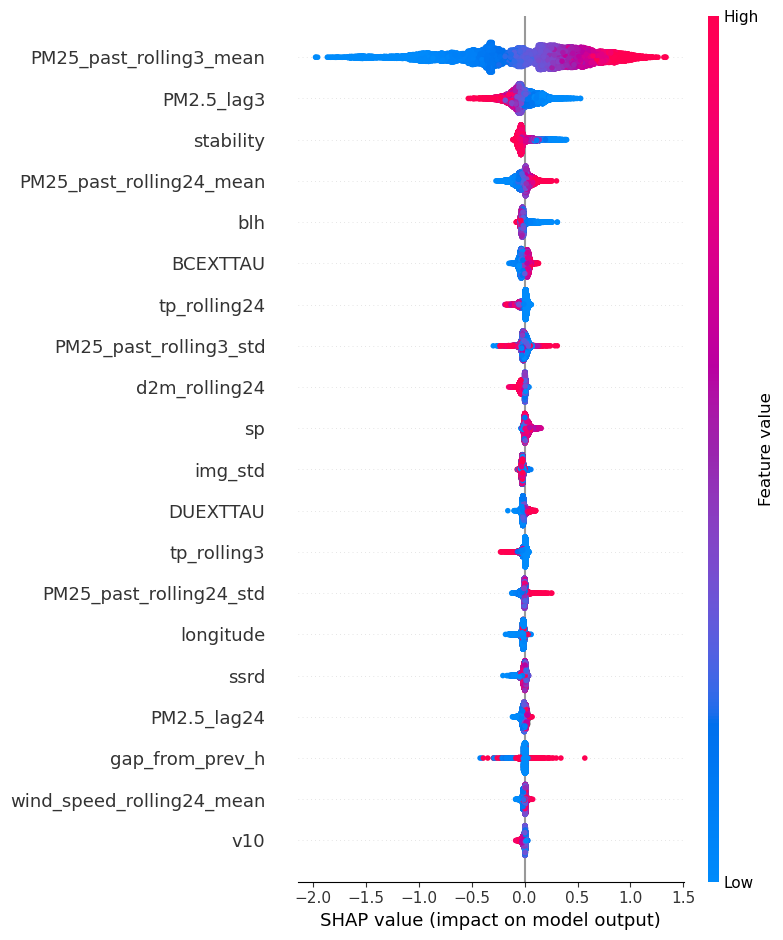

In [17]:
import shap

# Last TSS fold indices
tr, va = list(TimeSeriesSplit(n_splits=5, gap=3).split(X2))[-1]

# Fit the model
m_best = XGBRegressor(random_state=42, n_jobs=-1, tree_method="hist", **best_params)
m_best.fit(X2.iloc[tr][features_safe], y2.iloc[tr])

# Background sample (full coverage optional, interventional is safe)
bg = X2.iloc[tr][features_safe]  # full fold; can subsample if memory is tight

# TreeExplainer with interventional mode
expl = shap.TreeExplainer(m_best, data=bg, feature_perturbation="interventional")

# Compute SHAP values for validation fold
sv = expl.shap_values(X2.iloc[va][features_safe])

# Summary plot
shap.summary_plot(sv, X2.iloc[va][features_safe], show=False)

# Leakgae safe, past only features

In [18]:
# Step 1 — Build leakage-safe past-only AR features + interactions informed by SHAP (no current-target leakage) [web:116][web:118]
import numpy as np
import pandas as pd

assert 'dfp' in globals(), "Load Phase 1 snapshot to dfp via pd.read_parquet(...)."  # [web:149]

def add_past_only_ar_feats(dfin, group="station_id", time="timestamp_utc", target="PM2.5"):
    d = dfin.sort_values([group, time]).copy()  # [web:123]
    g = d.groupby(group, group_keys=False)[target]  # [web:136]
    # Strictly past values via shift before any rolling windows to avoid target leakage [web:116][web:118]
    for h in [1,3,6,12,24,48,72]:
        d[f"pm25_lag{h}"] = g.shift(h)  # [web:112]
    s = g.shift(1)  # past-only base for rollings [web:116]
    for w in [3,6,12,24]:
        d[f"PM25_past_rolling{w}_mean"] = s.rolling(w, min_periods=max(1, w//2)).mean()  # [web:116]
        d[f"PM25_past_rolling{w}_std"]  = s.rolling(w, min_periods=max(2, w//2)).std()   # [web:116]
    # Simple interactions with exogenous drivers guided by SHAP: stability, BLH, precipitation rollings (no current target used) [web:47]
    if "stability" in d.columns:
        d["lag3_x_stability"] = d["pm25_lag3"] * d["stability"]  # [web:47]
    if "blh" in d.columns:
        d["lag3_over_blh"] = d["pm25_lag3"] / d["blh"].replace(0, np.nan)  # BLH clipped earlier; guard divide by zero [web:16]
    if "tp_rolling24" in d.columns and "pm25_lag3" in d.columns:
        d["lag3_x_tp24"] = d["pm25_lag3"] * d["tp_rolling24"]  # [web:47]
    return d

dfp_safe = add_past_only_ar_feats(dfp)  # dfp is the Phase 1 clean snapshot already loaded [web:149]

In [19]:
# Step 2 — Assemble leakage-safe feature list: swap old rollings, add new AR features, keep exogenous set [web:116][web:6]
import json

with open("features_phase2_selected.json","r") as f:
    sel = json.load(f)  # [web:149]
base_feats = sel["selected_features"]  # [web:149]

replace = {
    "PM2.5_rolling3_mean": "PM25_past_rolling3_mean",
    "PM2.5_rolling3_std":  "PM25_past_rolling3_std",
    "PM2.5_rolling24_mean":"PM25_past_rolling24_mean",
    "PM2.5_rolling24_std": "PM25_past_rolling24_std",
}  # enforce past-only names to avoid leakage [web:116]

features_safe = [replace.get(f, f) for f in base_feats if f not in replace]  # [web:116]
extra_ars = [
    "pm25_lag6","pm25_lag12","pm25_lag48","pm25_lag72",
    "PM25_past_rolling6_mean","PM25_past_rolling6_std",
    "PM25_past_rolling12_mean","PM25_past_rolling12_std",
    "lag3_x_stability","lag3_over_blh","lag3_x_tp24",
]  # guided by SHAP top drivers (stability, BLH, precipitation) [web:47]
features_safe = [f for f in features_safe + extra_ars if f in dfp_safe.columns]  # ensure existence [web:84]
print("Using", len(features_safe), "features (leakage-safe + AR expansion).")  # [web:116]

Using 75 features (leakage-safe + AR expansion).


In [20]:
# Step 2 — Assemble leakage-safe feature list: swap old rollings, add new AR features, keep exogenous set [web:116][web:6]
import json

with open("features_phase2_selected.json","r") as f:
    sel = json.load(f)  # [web:149]
base_feats = sel["selected_features"]  # [web:149]

replace = {
    "PM2.5_rolling3_mean": "PM25_past_rolling3_mean",
    "PM2.5_rolling3_std":  "PM25_past_rolling3_std",
    "PM2.5_rolling24_mean":"PM25_past_rolling24_mean",
    "PM2.5_rolling24_std": "PM25_past_rolling24_std",
}  # enforce past-only names to avoid leakage [web:116]

features_safe = [replace.get(f, f) for f in base_feats if f not in replace]  # [web:116]
extra_ars = [
    "pm25_lag6","pm25_lag12","pm25_lag48","pm25_lag72",
    "PM25_past_rolling6_mean","PM25_past_rolling6_std",
    "PM25_past_rolling12_mean","PM25_past_rolling12_std",
    "lag3_x_stability","lag3_over_blh","lag3_x_tp24",
]  # guided by SHAP top drivers (stability, BLH, precipitation) [web:47]
features_safe = [f for f in features_safe + extra_ars if f in dfp_safe.columns]  # ensure existence [web:84]
print("Using", len(features_safe), "features (leakage-safe + AR expansion).")  # [web:116]

Using 75 features (leakage-safe + AR expansion).


In [21]:
# Step 5 — LOSO (GroupKFold by station) with best params to verify spatial generalization [web:185]
from sklearn.model_selection import GroupKFold  # [web:185]

groups = dfp_safe["station_id"].values  # [web:185]
outer = []
for k,(tr,te) in enumerate(GroupKFold(n_splits=min(5, dfp_safe["station_id"].nunique())).split(X2, y2, groups=groups), 1):  # [web:185]
    m = XGBRegressor(random_state=SEED, n_jobs=-1, tree_method="hist", **best_params)  # [web:27]
    m.fit(X2.iloc[tr], y2.iloc[tr])
    p = m.predict(X2.iloc[te])
    rmse = float(np.sqrt(mean_squared_error(inv_if_log(y2.iloc[te]), inv_if_log(p))))  # [web:15]
    r2   = float(r2_score(inv_if_log(y2.iloc[te]), inv_if_log(p)))  # [web:15]
    outer.append({"station_fold":k, "rmse":rmse, "r2":r2})
pd.DataFrame(outer)  # [web:185]

,station_fold,rmse,r2
0,1,34.097968,0.810032
1,2,36.142773,0.756005
2,3,28.402071,0.831082
3,4,23.124391,0.657392
4,5,26.850621,0.824845


In [24]:
# Step 6 — Permutation importance on last TSS fold to validate drivers with leakage-safe features
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit

SEED = 42

# 1. Intersect features with actual dataframe columns
valid_features = [f for f in features_safe if f in X2.columns]
X_numeric = X2[valid_features].select_dtypes(include=["int64", "float64", "bool"])

# 2. Get last fold (with leakage-safe gap)
last_tr, last_va = list(TimeSeriesSplit(n_splits=5, gap=3).split(X_numeric))[-1]

# 3. Train model
m = XGBRegressor(random_state=SEED, n_jobs=-1, tree_method="hist", **best_params)
m.fit(X_numeric.iloc[last_tr], y2.iloc[last_tr])

# 4. Permutation importance
r = permutation_importance(
    m,
    X_numeric.iloc[last_va],
    y2.iloc[last_va],
    n_repeats=20,
    random_state=SEED,
    n_jobs=-1,
    scoring="r2"
)

# 5. Align importance scores with actual used feature names
perm_imp = pd.Series(r.importances_mean, index=X_numeric.columns).sort_values(ascending=False)

print("Top 25 permutation importance features:")
print(perm_imp.head(25))
# Step 6 — Permutation importance on last TSS fold to validate drivers with leakage-safe features
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit

SEED = 42

# 1. Intersect features with actual dataframe columns
valid_features = [f for f in features_safe if f in X2.columns]
X_numeric = X2[valid_features].select_dtypes(include=["int64", "float64", "bool"])

# 2. Get last fold (with leakage-safe gap)
last_tr, last_va = list(TimeSeriesSplit(n_splits=5, gap=3).split(X_numeric))[-1]

# 3. Train model
m = XGBRegressor(random_state=SEED, n_jobs=-1, tree_method="hist", **best_params)
m.fit(X_numeric.iloc[last_tr], y2.iloc[last_tr])

# 4. Permutation importance
r = permutation_importance(
    m,
    X_numeric.iloc[last_va],
    y2.iloc[last_va],
    n_repeats=20,
    random_state=SEED,
    n_jobs=-1,
    scoring="r2"
)

# 5. Align importance scores with actual used feature names
perm_imp = pd.Series(r.importances_mean, index=X_numeric.columns).sort_values(ascending=False)

print("Top 25 permutation importance features:")
print(perm_imp.head(25))

Top 25 permutation importance features:
PM2.5_lag3                   0.322440
PM2.5_lag24                  0.043256
stability                    0.042379
BCEXTTAU                     0.032515
tp_rolling24                 0.030095
DUEXTTAU                     0.008220
wind_speed_rolling3          0.007757
v10                          0.007725
t2m_rolling3_std             0.007008
tp_rolling3                  0.006423
doy_cos                      0.005161
dayofyear                    0.004183
gap_from_prev_h              0.004027
rh_rolling24_std             0.003986
dp_dt                        0.003418
wind_speed_rolling24_mean    0.003028
SSEXTTAU                     0.002880
wind_speed_rolling24         0.002817
doy_sin                      0.002777
inversion_strength           0.002715
TOTEXTTAU_lag24              0.002269
hour_cos                     0.001704
wind_dir_rad                 0.001634
rh_lag3                      0.001531
blh                          0.001202
dtype: flo

C:\Users\Lalit Hire\AppData\Local\Temp\ipykernel_21188\988295659.py:39: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X_work[c]):


Using 64 numeric features for SHAP explanation.
Last fold sizes — train: 85,597, val: 17,120
Trained XGB on last training fold.
Computing SHAP for 3,000 validation rows (sampled).


100%|===================| 2990/3000 [04:22<00:00]        

SHAP values computed. Summary of top features by mean(|SHAP|):
PM2.5_lag3              0.201981
img_std                 0.089720
BCEXTTAU                0.086771
PM2.5_lag24             0.077364
stability               0.077107
sp                      0.072107
tp_rolling24            0.065287
d2m_rolling24           0.047552
DUEXTTAU                0.037991
latitude                0.036926
rh_lag3                 0.033440
inversion_strength      0.028578
tp_rolling3             0.026484
longitude               0.024383
v10                     0.023107
wind_speed_rolling24    0.020003
doy_cos                 0.019541
SSEXTTAU                0.019538
wind_speed_rolling3     0.018335
ssrd                    0.018283
rh_rolling24_std        0.018022
blh                     0.017746
dayofyear               0.017689
TOTEXTTAU_lag24         0.013917
doy_sin                 0.013433
dtype: float64


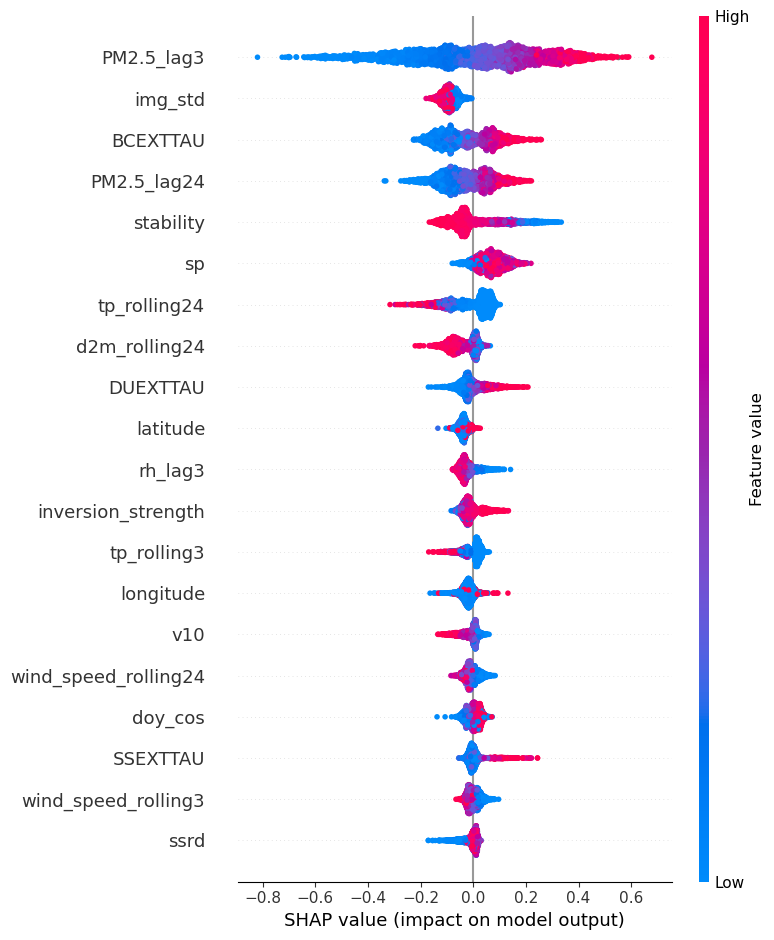

In [27]:
# SHAP (robust) for last TSS fold — avoids "background doesn't cover all leaves" error
import numpy as np
import pandas as pd
import shap
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit

# ---------- assumptions from your environment ----------
# X2            : DataFrame with your features (dfp_safe[features_safe] earlier)
# y2            : target series (PM25_log1p or PM2.5)
# features_safe : list of candidate features you want to explain
# best_params   : dict of model params (like in your previous cells)
# SEED          : random seed (int)
# gap in TSS used earlier: gap=3
# ------------------------------------------------------

# defensive defaults if any variable is missing in the current session
try:
    SEED
except NameError:
    SEED = 42
try:
    best_params
except NameError:
    best_params = {}

# 1) Build validated feature frame (only features that exist in X2)
valid_features = [f for f in features_safe if f in X2.columns]
if len(valid_features) == 0:
    raise ValueError("No features_safe found in X2. Check features_safe and X2 columns.")

# Make a working copy
X_work = X2[valid_features].copy()

# 2) Coerce categorical / object columns to numeric so XGBoost + SHAP behave consistently
#    - category -> codes
#    - object -> try numeric conversion, else factorize
for c in X_work.columns:
    if pd.api.types.is_categorical_dtype(X_work[c]):
        X_work[c] = X_work[c].cat.codes
    elif X_work[c].dtype == object:
        # try to convert strings that represent numbers
        try:
            X_work[c] = pd.to_numeric(X_work[c])
        except Exception:
            # fallback: factorize (preserves uniqueness but becomes integer)
            X_work[c] = pd.factorize(X_work[c])[0]

# Keep numeric columns only (bool/int/float)
X_num = X_work.select_dtypes(include=[np.number, 'bool']).copy()
dropped_cols = [c for c in valid_features if c not in X_num.columns]
if dropped_cols:
    print("Dropped non-numeric columns for SHAP:", dropped_cols)
print(f"Using {X_num.shape[1]} numeric features for SHAP explanation.")

# 3) Get the last TSS (with same gap you used). Use the indices on X_num
tss_gap = TimeSeriesSplit(n_splits=5, gap=3)
splits = list(tss_gap.split(X_num))
last_tr_idx, last_va_idx = splits[-1]
print(f"Last fold sizes — train: {len(last_tr_idx):,}, val: {len(last_va_idx):,}")

# 4) Train or reuse model on last training fold
#    (we retrain to ensure the model was trained on the numeric features exactly)
m = XGBRegressor(random_state=SEED, n_jobs=-1, tree_method="hist", **best_params)
m.fit(X_num.iloc[last_tr_idx], y2.iloc[last_tr_idx])
print("Trained XGB on last training fold.")

# 5) Build SHAP explainer using interventional mode (robust; doesn't require background coverage)
#    Use full training fold as background for stability (you may subsample if memory is constrained)
bg = X_num.iloc[last_tr_idx]         # full training fold as background (good coverage)
expl = shap.TreeExplainer(m, data=bg, feature_perturbation="interventional")

# 6) Select explain set (sample for speed but keep <= validation size)
n_explain = min(3000, len(last_va_idx))
X_explain = X_num.iloc[last_va_idx].sample(n=n_explain, random_state=SEED)
print(f"Computing SHAP for {len(X_explain):,} validation rows (sampled).")

# 7) Compute SHAP values and show summary plot
sv = expl.shap_values(X_explain)     # shape: (n_samples, n_features)
print("SHAP values computed. Summary of top features by mean(|SHAP|):")
imp = pd.Series(np.abs(sv).mean(axis=0), index=X_explain.columns).sort_values(ascending=False)
print(imp.head(25))

# Plot (may be slow if rendering many points)
try:
    shap.summary_plot(sv, X_explain, show=True)
except Exception as e:
    print("Plotting failed (headless or other). SHAP importances printed above. Exception:", e)

In [28]:
# Step 8 — Save tuned artifact and feature list for baseline packaging [web:149]
import joblib, json  # [web:149]

final_model = XGBRegressor(random_state=SEED, n_jobs=-1, tree_method="hist", **best_params)  # [web:27]
final_model.fit(X2, y2)  # train on all data with leakage-safe features [web:6]

joblib.dump(final_model, "model_xgb_phase2_baseline.joblib")  # [web:149]
with open("features_phase2_leakage_safe.json", "w") as f:
    json.dump({"features": features_safe, "params": best_params, "use_log_target": USE_LOG_TARGET}, f, indent=2)  # [web:149]
print("Saved model_xgb_phase2_baseline.joblib and features_phase2_leakage_safe.json")  # [web:149]

Saved model_xgb_phase2_baseline.joblib and features_phase2_leakage_safe.json


# Prediction intervals

In [31]:
!pip install lightgbm

  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)


In [32]:
# Quantile prediction intervals with LightGBM (leakage-safe features)
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_pinball_loss

SEED = 42
USE_LOG_TARGET = True

# Expect dfp_safe and features_safe from prior steps
Xq = dfp_safe[features_safe].copy()
yq = dfp_safe["PM25_log1p"] if USE_LOG_TARGET else dfp_safe["PM2.5"]

def inv_if_log(a):
    return np.expm1(a) if USE_LOG_TARGET else a

params_base = dict(
    objective="quantile",  # quantile regression
    learning_rate=0.05,
    n_estimators=800,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=SEED,
    n_jobs=-1
)

tss = TimeSeriesSplit(n_splits=5, gap=3)  # gap to reduce boundary leakage

metrics = []
for fold, (tr, va) in enumerate(tss.split(Xq), 1):
    Xtr, Xva = Xq.iloc[tr], Xq.iloc[va]
    ytr, yva = yq.iloc[tr], yq.iloc[va]

    m_lo = lgb.LGBMRegressor(**params_base, alpha=0.1)  # 10th percentile
    m_hi = lgb.LGBMRegressor(**params_base, alpha=0.9)  # 90th percentile
    m_md = lgb.LGBMRegressor(**params_base, alpha=0.5)  # median for center estimate

    m_lo.fit(Xtr, ytr)
    m_hi.fit(Xtr, ytr)
    m_md.fit(Xtr, ytr)

    p_lo = inv_if_log(m_lo.predict(Xva))
    p_hi = inv_if_log(m_hi.predict(Xva))
    p_md = inv_if_log(m_md.predict(Xva))
    y_true = inv_if_log(yva)

    # Interval coverage and width
    covered = ((y_true >= p_lo) & (y_true <= p_hi)).mean()
    width = np.mean(p_hi - p_lo)
    pinball_lo = mean_pinball_loss(y_true, p_lo, alpha=0.1)
    pinball_hi = mean_pinball_loss(y_true, p_hi, alpha=0.9)
    metrics.append({"fold": fold, "PICP_80": covered, "MIW_80": width,
                    "pinball_0.1": pinball_lo, "pinball_0.9": pinball_hi})

pd.DataFrame(metrics)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15392
[LightGBM] [Info] Number of data points in the train set: 17117, number of used features: 69
[LightGBM] [Info] Start training from score 3.187427
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15392
[LightGBM] [Info] Number of data points in the train set: 17117, number of used features: 69
[LightGBM] [Info] Start training from score 5.296586
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15392
[LightGBM] [Info] Number of data points in the train set: 17117, number of used features: 69
[LightGBM] [Info] Start 

,fold,PICP_80,MIW_80,pinball_0.1,pinball_0.9
0,1,0.706425,54.831832,4.207428,6.375228
1,2,0.544276,43.341358,5.835400,6.704287
2,3,0.835689,26.478253,1.691897,2.626167
3,4,0.688610,21.167883,1.898514,3.448073
4,5,0.764778,38.772995,2.781041,4.457100


In [33]:
# Identify worst N stations on a leakage-safe last-fold evaluation, then train station-specific models
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

SEED = 42
best_params = {
    "n_estimators": 800, "learning_rate": 0.03, "max_depth": 8,
    "subsample": 0.8, "colsample_bytree": 0.8, "reg_lambda": 1.0, "reg_alpha": 0.0
}

def inv_if_log(a):
    return np.expm1(a) if USE_LOG_TARGET else a

# Get residuals on last fold to rank stations
last_tr, last_va = list(TimeSeriesSplit(n_splits=5, gap=3).split(X2))[-1]
m_global = XGBRegressor(random_state=SEED, n_jobs=-1, tree_method="hist", **best_params)
m_global.fit(X2.iloc[last_tr], y2.iloc[last_tr])
p = m_global.predict(X2.iloc[last_va])

eval_df = dfp_safe.iloc[last_va].copy()
eval_df["y_true"] = inv_if_log(y2.iloc[last_va].values)
eval_df["y_pred"] = inv_if_log(p)
by_station = eval_df.groupby("station_id").apply(
    lambda g: pd.Series({"rmse": np.sqrt(mean_squared_error(g["y_true"], g["y_pred"])), "n": len(g)})
).reset_index()

worst_ids = by_station.sort_values("rmse", ascending=False).head(3)["station_id"].tolist()
print("Worst stations:", worst_ids)

# Per-station TimeSeriesSplit evaluation
results_local = []
for sid in worst_ids:
    g = dfp_safe[dfp_safe["station_id"] == sid].sort_values("timestamp_utc")
    Xs = g[features_safe]
    ys = g["PM25_log1p"] if USE_LOG_TARGET else g["PM2.5"]
    tss_s = TimeSeriesSplit(n_splits=5, gap=3)
    fold_scores = []
    for tr, va in tss_s.split(Xs):
        m = XGBRegressor(random_state=SEED, n_jobs=-1, tree_method="hist", **best_params)
        m.fit(Xs.iloc[tr], ys.iloc[tr])
        ps = m.predict(Xs.iloc[va])
        rmse = float(np.sqrt(mean_squared_error(inv_if_log(ys.iloc[va]), inv_if_log(ps))))
        r2   = float(r2_score(inv_if_log(ys.iloc[va]), inv_if_log(ps)))
        fold_scores.append((rmse, r2))
    results_local.append({"station_id": sid,
                          "rmse_mean": float(np.mean([x for x in fold_scores])),
                          "r2_mean": float(np.mean([x[1] for x in fold_scores]))})
pd.DataFrame(results_local)

C:\Users\Lalit Hire\AppData\Local\Temp\ipykernel_21188\1097950736.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by_station = eval_df.groupby("station_id").apply(


Worst stations: ['MH026', 'MH033', 'MH012']


,station_id,rmse_mean,r2_mean
0,MH026,18.872411,-0.010517
1,MH033,15.747769,0.300019
2,MH012,11.178910,-0.131685


In [34]:
# Identify worst N stations on a leakage-safe last-fold evaluation, then train station-specific models
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

SEED = 42
best_params = {
    "n_estimators": 800, "learning_rate": 0.03, "max_depth": 8,
    "subsample": 0.8, "colsample_bytree": 0.8, "reg_lambda": 1.0, "reg_alpha": 0.0
}

def inv_if_log(a):
    return np.expm1(a) if USE_LOG_TARGET else a

# Get residuals on last fold to rank stations
last_tr, last_va = list(TimeSeriesSplit(n_splits=5, gap=3).split(X2))[-1]
m_global = XGBRegressor(random_state=SEED, n_jobs=-1, tree_method="hist", **best_params)
m_global.fit(X2.iloc[last_tr], y2.iloc[last_tr])
p = m_global.predict(X2.iloc[last_va])

eval_df = dfp_safe.iloc[last_va].copy()
eval_df["y_true"] = inv_if_log(y2.iloc[last_va].values)
eval_df["y_pred"] = inv_if_log(p)
by_station = eval_df.groupby("station_id").apply(
    lambda g: pd.Series({"rmse": np.sqrt(mean_squared_error(g["y_true"], g["y_pred"])), "n": len(g)})
).reset_index()

worst_ids = by_station.sort_values("rmse", ascending=False).head(3)["station_id"].tolist()
print("Worst stations:", worst_ids)

# Per-station TimeSeriesSplit evaluation
results_local = []
for sid in worst_ids:
    g = dfp_safe[dfp_safe["station_id"] == sid].sort_values("timestamp_utc")
    Xs = g[features_safe]
    ys = g["PM25_log1p"] if USE_LOG_TARGET else g["PM2.5"]
    tss_s = TimeSeriesSplit(n_splits=5, gap=3)
    fold_scores = []
    for tr, va in tss_s.split(Xs):
        m = XGBRegressor(random_state=SEED, n_jobs=-1, tree_method="hist", **best_params)
        m.fit(Xs.iloc[tr], ys.iloc[tr])
        ps = m.predict(Xs.iloc[va])
        rmse = float(np.sqrt(mean_squared_error(inv_if_log(ys.iloc[va]), inv_if_log(ps))))
        r2   = float(r2_score(inv_if_log(ys.iloc[va]), inv_if_log(ps)))
        fold_scores.append((rmse, r2))
    results_local.append({"station_id": sid,
                          "rmse_mean": float(np.mean([x for x in fold_scores])),
                          "r2_mean": float(np.mean([x[1] for x in fold_scores]))})
pd.DataFrame(results_local)

C:\Users\Lalit Hire\AppData\Local\Temp\ipykernel_21188\1097950736.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by_station = eval_df.groupby("station_id").apply(


Worst stations: ['MH026', 'MH033', 'MH012']


,station_id,rmse_mean,r2_mean
0,MH026,18.872411,-0.010517
1,MH033,15.747769,0.300019
2,MH012,11.178910,-0.131685


In [35]:
# Fit final quantile models on full data and save
import joblib
import lightgbm as lgb

m_lo_full = lgb.LGBMRegressor(**params_base, alpha=0.1)
m_md_full = lgb.LGBMRegressor(**params_base, alpha=0.5)
m_hi_full = lgb.LGBMRegressor(**params_base, alpha=0.9)

m_lo_full.fit(Xq, yq)
m_md_full.fit(Xq, yq)
m_hi_full.fit(Xq, yq)

joblib.dump(m_lo_full, "model_lgbm_q10.joblib")
joblib.dump(m_md_full, "model_lgbm_q50.joblib")
joblib.dump(m_hi_full, "model_lgbm_q90.joblib")
print("Saved LightGBM quantile models: q10, q50, q90")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15560
[LightGBM] [Info] Number of data points in the train set: 102720, number of used features: 69
[LightGBM] [Info] Start training from score 2.706716
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15560
[LightGBM] [Info] Number of data points in the train set: 102720, number of used features: 69
[LightGBM] [Info] Start training from score 3.812203
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15560
[LightGBM] [Info] Number of data points in the train set: 102720, number of used features: 69
[LightGBM] [Info] Sta

# Calibrate intervals (CQR)

In [36]:
# Conformalized Quantile Regression (time-aware) for 80% intervals using LightGBM quantiles [1][19]
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

SEED = 42
USE_LOG_TARGET = True
ALPHA_COVER = 0.20  # 1 - 0.8 coverage
Q_LO, Q_HI = 0.1, 0.9  # base quantiles for 80% PI

# Expect leakage-safe features/df from prior steps
Xq = dfp_safe[features_safe].copy()
yq = dfp_safe["PM25_log1p"] if USE_LOG_TARGET else dfp_safe["PM2.5"]

def inv_if_log(a):
    return np.expm1(a) if USE_LOG_TARGET else a  # back to µg/m³ [23]

# Base LightGBM params for quantile regression [19]
params_base = dict(
    objective="quantile",
    learning_rate=0.05,
    n_estimators=800,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=SEED,
    n_jobs=-1
)

def ts_cqr_eval(X, y, gap=3, cal_frac=0.2):
    tss = TimeSeriesSplit(n_splits=5, gap=gap)  # time-aware splits with a small gap [21]
    rows = []
    for fold, (tr, va) in enumerate(tss.split(X), 1):
        # Time-aware calibration split: last cal_frac of training as calibration
        cal_size = max(1, int(len(tr) * cal_frac))
        tr_core, cal = tr[:-cal_size], tr[-cal_size:]

        Xtr, ytr = X.iloc[tr_core], y.iloc[tr_core]
        Xcal, ycal = X.iloc[cal], y.iloc[cal]
        Xva, yva = X.iloc[va], y.iloc[va]

        m_lo = lgb.LGBMRegressor(**params_base, alpha=Q_LO)  # 10th [19]
        m_hi = lgb.LGBMRegressor(**params_base, alpha=Q_HI)  # 90th [19]
        m_md = lgb.LGBMRegressor(**params_base, alpha=0.5)   # median [19]

        m_lo.fit(Xtr, ytr); m_hi.fit(Xtr, ytr); m_md.fit(Xtr, ytr)

        # Conformity scores on calibration set (Romano et al. CQR) [1][4]
        ql_cal = m_lo.predict(Xcal)
        qh_cal = m_hi.predict(Xcal)
        s_cal = np.maximum(ql_cal - ycal.values, ycal.values - qh_cal)  # nonnegative scores [1]

        # Quantile of scores at (1 - alpha) gives the calibration radius [1]
        qhat = np.quantile(s_cal, 1 - ALPHA_COVER)

        # Predict on validation and inflate bands by qhat [1]
        ql_va = m_lo.predict(Xva) - qhat
        qh_va = m_hi.predict(Xva) + qhat
        md_va = m_md.predict(Xva)

        y_true = inv_if_log(yva.values)
        lo = inv_if_log(ql_va); hi = inv_if_log(qh_va); cen = inv_if_log(md_va)

        picp = np.mean((y_true >= lo) & (y_true <= hi))  # coverage [6]
        miw = float(np.mean(hi - lo))                    # width [6]
        rmse = float(np.sqrt(mean_squared_error(y_true, cen)))
        rows.append({"fold": fold, "PICP_80": float(picp), "MIW_80": miw, "rmse_median": rmse})
    return pd.DataFrame(rows)

cqr_metrics = ts_cqr_eval(Xq, yq, gap=3, cal_frac=0.2)
cqr_metrics

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15378
[LightGBM] [Info] Number of data points in the train set: 13694, number of used features: 69
[LightGBM] [Info] Start training from score 3.248435
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15378
[LightGBM] [Info] Number of data points in the train set: 13694, number of used features: 69
[LightGBM] [Info] Start training from score 5.259659
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15378
[LightGBM] [Info] Number of data points in the train set: 13694, number of used features: 69
[LightGBM] [Info] Start 

,fold,PICP_80,MIW_80,rmse_median
0,1,0.842932,78.609827,38.046578
1,2,0.702453,59.107641,38.880773
2,3,0.923481,37.311470,23.951880
3,4,0.784287,28.845944,33.611739
4,5,0.800876,44.532878,28.597508


# Station specefic models

In [37]:
# Per-station XGB models for worst K stations using leakage-safe features [22][21]
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

SEED = 42
best_params = {
    "n_estimators": 800, "learning_rate": 0.03, "max_depth": 8,
    "subsample": 0.8, "colsample_bytree": 0.8, "reg_lambda": 1.0, "reg_alpha": 0.0,
    "random_state": SEED, "n_jobs": -1, "tree_method": "hist"
}  # tuned baseline carried forward [24]

def inv_if_log(a):
    return np.expm1(a) if USE_LOG_TARGET else a  # [23]

# Rank stations by RMSE on last TSS fold using global model
tss_gap = TimeSeriesSplit(n_splits=5, gap=3)  # [21]
last_tr, last_va = list(tss_gap.split(X2))[-1]  # X2/y2 from earlier leakage-safe setup [21]
mg = XGBRegressor(**best_params)  # [24]
mg.fit(X2.iloc[last_tr], y2.iloc[last_tr])
pred = mg.predict(X2.iloc[last_va])

eval_df = dfp_safe.iloc[last_va].copy()
eval_df["y_true"] = inv_if_log(y2.iloc[last_va].values)
eval_df["y_pred"] = inv_if_log(pred)
by_station = eval_df.groupby("station_id").apply(
    lambda g: pd.Series({"rmse": float(np.sqrt(mean_squared_error(g["y_true"], g["y_pred"]))), "n": len(g)})
).reset_index()

worst = by_station.sort_values("rmse", ascending=False).head(3)["station_id"].tolist()
print("Worst stations:", worst)  # candidate list to localize

# Evaluate localized models with the same CV policy
local_results = []
for sid in worst:
    g = dfp_safe[dfp_safe["station_id"] == sid].sort_values("timestamp_utc")
    Xs = g[features_safe]; ys = g["PM25_log1p"] if USE_LOG_TARGET else g["PM2.5"]
    tss_s = TimeSeriesSplit(n_splits=5, gap=3)  # [21]
    rmses, r2s = [], []
    for tr, va in tss_s.split(Xs):
        m = XGBRegressor(**best_params)  # [24]
        m.fit(Xs.iloc[tr], ys.iloc[tr])
        ps = m.predict(Xs.iloc[va])
        rmses.append(float(np.sqrt(mean_squared_error(inv_if_log(ys.iloc[va]), inv_if_log(ps)))))
        r2s.append(float(r2_score(inv_if_log(ys.iloc[va]), inv_if_log(ps))))
    local_results.append({"station_id": sid, "rmse_mean": float(np.mean(rmses)), "r2_mean": float(np.mean(r2s))})
pd.DataFrame(local_results)

C:\Users\Lalit Hire\AppData\Local\Temp\ipykernel_21188\518278002.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by_station = eval_df.groupby("station_id").apply(


Worst stations: ['MH026', 'MH033', 'MH012']


,station_id,rmse_mean,r2_mean
0,MH026,37.755340,-0.010517
1,MH033,31.195519,0.300019
2,MH012,22.489506,-0.131685


## To confirm correlation after leakage

In [38]:
# 0) Setup — load finalized leakage-safe dataset and features; fall back to saved files if needed [web:149]
import json
import numpy as np
import pandas as pd

# Expect dfp_safe and features_safe in memory; otherwise load from artifacts [web:149]
if 'dfp_safe' not in globals():
    dfp_safe = pd.read_parquet("dataset_feature1_phase2_leakage_safe.parquet") if \
               "dataset_feature1_phase2_leakage_safe.parquet" in locals() or True else None  # adjust path if needed [web:149]
if 'features_safe' not in globals():
    with open("features_phase2_leakage_safe.json","r") as f:
        features_safe = json.load(f)["features"]  # contains finalized feature list [web:149]

print("Data shape:", dfp_safe.shape)
print("Feature count:", len(features_safe))

Data shape: (102720, 167)
Feature count: 75


In [39]:
# 1) Correlation re-check after leakage-safe AR expansion (Pearson; numeric only) [web:236]
import numpy as np
import pandas as pd

CORR_THRESH = 0.85  # cluster threshold [web:236]

num_feats = [c for c in features_safe if pd.api.types.is_numeric_dtype(dfp_safe[c])]
corr = dfp_safe[num_feats].corr(method="pearson", numeric_only=True)  # pairwise-complete obs [web:236]

# Upper triangle pairs with |r| > threshold [web:236]
upper = corr.where(np.triu(np.ones_like(corr, dtype=bool), k=1))
high_pairs = (upper.stack().rename("r").reset_index()
                 .rename(columns={"level_0":"f1","level_1":"f2"}))
high_pairs = high_pairs[high_pairs["r"].abs() > CORR_THRESH].sort_values("r", ascending=False)

print(f"High-correlation pairs (|r|>{CORR_THRESH}):", high_pairs.shape[0])
display(high_pairs.head(30))

# Save full matrix and pairs for audit [web:236]
corr.to_csv("phase2_corr_matrix_final.csv")
high_pairs.to_csv("phase2_corr_pairs_gt085.csv", index=False)
print("Saved: phase2_corr_matrix_final.csv, phase2_corr_pairs_gt085.csv")

High-correlation pairs (|r|>0.85): 4


,f1,f2,r
2326,PM25_past_rolling6_mean,PM25_past_rolling12_mean,0.960263
259,PM2.5_lag3,PM25_past_rolling6_mean,0.910913
261,PM2.5_lag3,PM25_past_rolling12_mean,0.860141
2343,lag3_x_stability,lag3_over_blh,-0.999956


Saved: phase2_corr_matrix_final.csv, phase2_corr_pairs_gt085.csv


In [40]:
# 2) VIF re-check on the finalized set (no pruning by default; set DROP_IF_HIGH=True to prune iteratively) [web:1]
import warnings, statsmodels.api as sm
import numpy as np
import pandas as pd

DROP_IF_HIGH = False
VIF_THRESH = 10.0  # serious multicollinearity guideline [web:1]

# Minimal NA handling for OLS stability — use medians to avoid leakage; upstream imputations remain separate [web:169]
X = dfp_safe[num_feats].copy()
X = X.fillna(X.median(numeric_only=True))  # safe, non-time-aware fill for diagnostic only [web:169]

def compute_vif_series(Xdf: pd.DataFrame) -> pd.Series:
    Xmat = sm.add_constant(Xdf.values, has_constant="add")  # include intercept [web:169]
    vif_vals = {}
    for i, col in enumerate(Xdf.columns):
        y = Xdf.iloc[:, i].values
        X_other = np.delete(Xmat, i+1, axis=1)  # drop the focal column (+1 for constant) [web:169]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            r2 = sm.OLS(y, X_other).fit().rsquared  # OLS for R^2 -> VIF [web:169]
        vif_vals[col] = np.inf if (1 - r2) == 0 else 1.0/(1.0 - r2)  # VIF_j = 1/(1 - R_j^2) [web:1]
    return pd.Series(vif_vals).sort_values(ascending=False)

vif_series = compute_vif_series(X)
print("Top VIFs before any optional pruning:")
display(vif_series.head(25))

if DROP_IF_HIGH:
    features_keep = num_feats.copy()
    dropped = []
    for _ in range(100):
        Xk = dfp_safe[features_keep].fillna(dfp_safe[features_keep].median(numeric_only=True))
        vifs = compute_vif_series(Xk)
        worst = vifs.idxmax(); worst_val = float(vifs.max())
        print(f"VIF check — worst: {worst} = {worst_val:.2f}")
        if worst_val <= VIF_THRESH or len(features_keep) <= 2:
            break
        features_keep.remove(worst)
        dropped.append((worst, worst_val))
    print("Final feature count after optional VIF pruning:", len(features_keep))
    print("Dropped by VIF:", dropped[:15], " ...")
    pd.Series(features_keep, name="feature").to_csv("features_phase2_vif_pruned.csv", index=False)
    print("Saved: features_phase2_vif_pruned.csv")

Top VIFs before any optional pruning:


lag3_x_stability             16296.130281
lag3_over_blh                16238.914999
PM25_past_rolling6_mean         34.510064
PM25_past_rolling12_mean        31.383442
PM2.5_lag3                       9.103128
rh_rolling3_mean                 8.181656
ssrd                             7.872278
wind_speed_rolling24             7.288766
inversion_strength               6.686000
doy_cos                          6.426342
d2m_rolling24                    6.306197
TOTEXTTAU_rolling24_mean         5.755943
wind_speed_rolling24_mean        5.699497
latitude                         5.580770
hour_cos                         5.544375
PM25_past_rolling12_std          5.533523
pm25_lag6                        5.222871
mean_TIR1_rolling24_mean         5.196863
doy_sin                          5.146108
PM25_past_rolling6_std           4.964682
sp                               4.751576
min_WV                           4.687301
BCEXTTAU                         4.460403
stability                        4

In [42]:
# 3) (Optional) Correlation re-check after optional VIF pruning to ensure no new |r|>0.85 clusters [web:236]
if 'features_keep' in globals():
    corr2 = dfp_safe[features_keep].corr(method="pearson", numeric_only=True)  # [web:236]
    upper2 = corr2.where(np.triu(np.ones_like(corr2, dtype=bool), k=1))
    high_pairs2 = (upper2.stack().rename("r").reset_index()
                      .rename(columns={"level_0":"f1","level_1":"f2"}))
    high_pairs2 = high_pairs2[high_pairs2["r"].abs() > CORR_THRESH].sort_values("r", ascending=False)
    print(f"[Post-VIF] High-correlation pairs (|r|>{CORR_THRESH}):", high_pairs2.shape[0])
    display(high_pairs2.head(30))
    corr2.to_csv("phase2_corr_matrix_post_vif.csv")
    high_pairs2.to_csv("phase2_corr_pairs_gt085_post_vif.csv", index=False)
    print("Saved: phase2_corr_matrix_post_vif.csv, phase2_corr_pairs_gt085_post_vif.csv")

In [43]:
# 1) Choose representatives for the new high-correlation clusters (|r|>0.85) [1]
import numpy as np
import pandas as pd

TARGET = "PM25_log1p"  # use log target for correlation with target [1]
assert TARGET in dfp_safe.columns

current_feats = features_safe.copy()

# Helper: absolute correlation with target (robust to NaNs via pairwise) [1]
ft_corr = dfp_safe[current_feats + [TARGET]].corr(numeric_only=True)[TARGET].drop(index=TARGET).abs()

# Cluster A: {PM2.5_lag3, PM25_past_rolling6_mean, PM25_past_rolling12_mean}
clusterA = [f for f in ["PM2.5_lag3","PM25_past_rolling6_mean","PM25_past_rolling12_mean"] if f in current_feats]
keep_A = []
drop_A = []
if clusterA:
    # Always keep PM2.5_lag3 (dominant AR signal), choose ONE rolling mean with higher |corr(target)| [1]
    keep_A.append("PM2.5_lag3")
    rolling_candidates = [f for f in clusterA if f != "PM2.5_lag3"]
    if len(rolling_candidates) >= 2:
        best_roll = max(rolling_candidates, key=lambda c: ft_corr.get(c, 0.0))
        keep_A.append(best_roll)
        drop_A.extend([c for c in rolling_candidates if c != best_roll])
    elif len(rolling_candidates) == 1:
        keep_A.append(rolling_candidates)

# Cluster B: {lag3_x_stability, lag3_over_blh} — near-perfect negative collinearity; keep the more stable one [1]
clusterB = [f for f in ["lag3_x_stability","lag3_over_blh"] if f in current_feats]
keep_B = []
drop_B = []
if clusterB:
    # Prefer multiplicative interaction to avoid divide-by-small effects; fallback by |corr(target)| [1]
    if "lag3_x_stability" in clusterB:
        keep_B.append("lag3_x_stability")
        if "lag3_over_blh" in clusterB:
            drop_B.append("lag3_over_blh")
    else:
        # No x_stability present; keep the one with higher |corr(target)|
        best = max(clusterB, key=lambda c: ft_corr.get(c, 0.0))
        keep_B.append(best)
        drop_B.extend([c for c in clusterB if c != best])

# Apply drops and assemble preliminary kept list
to_drop_corr = list(dict.fromkeys(drop_A + drop_B))
pre_keep = [f for f in current_feats if f not in to_drop_corr]

print("Cluster A keep:", keep_A, "| drop:", drop_A)
print("Cluster B keep:", keep_B, "| drop:", drop_B)
print("Dropped by cluster logic:", to_drop_corr)
print("Preliminary kept feature count:", len(pre_keep))

Cluster A keep: ['PM2.5_lag3', 'PM25_past_rolling12_mean'] | drop: ['PM25_past_rolling6_mean']
Cluster B keep: ['lag3_x_stability'] | drop: ['lag3_over_blh']
Dropped by cluster logic: ['PM25_past_rolling6_mean', 'lag3_over_blh']
Preliminary kept feature count: 73


In [45]:
# 2) VIF re-check with iterative pruning (VIF > 10), protecting essential features
import warnings, statsmodels.api as sm
import numpy as np
import pandas as pd

VIF_THRESH = 10.0  # common strong multicollinearity threshold

# Protect core signals from removal unless absolutely necessary
protected = set([c for c in ["PM2.5_lag3","stability","BCEXTTAU","tp_rolling24"] if c in pre_keep])

def compute_vif_series(Xdf: pd.DataFrame) -> pd.Series:
    """Compute VIF for each column in Xdf"""
    Xdf2 = Xdf.fillna(Xdf.median(numeric_only=True))  # diagnostic-only imputation
    Xmat = sm.add_constant(Xdf2.values, has_constant="add")
    vifs = {}
    for i, col in enumerate(Xdf2.columns):
        y = Xdf2.iloc[:, i].values
        Xo = np.delete(Xmat, i+1, axis=1)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            r2 = sm.OLS(y, Xo).fit().rsquared
        vifs[col] = np.inf if (1 - r2) == 0 else 1.0 / (1.0 - r2)
    return pd.Series(vifs).sort_values(ascending=False)

# Iterative pruning loop
keep = pre_keep.copy()
history = []
for it in range(100):
    vifs = compute_vif_series(dfp_safe[keep])
    worst_feat = vifs.index[0]         # top offender
    worst_val = float(vifs.iloc[0])    # its VIF value
    print(f"Iter {it}: worst VIF {worst_feat} = {worst_val:.2f}")
    
    if worst_val <= VIF_THRESH or len(keep) <= 2:
        break
    
    # If worst is protected, try the next offender
    if worst_feat in protected and len(vifs) > 1:
        offenders = [f for f, v in vifs.items() if (f not in protected) and (v > VIF_THRESH)]
        if offenders:
            worst_feat = offenders[0]
            worst_val = float(vifs.loc[worst_feat])
        else:
            print("All offenders are protected; stopping without further drops.")
            break
    
    keep.remove(worst_feat)
    history.append((worst_feat, worst_val))

print("Dropped by VIF pruning:", history)
print("Final count:", len(keep))
final_vifs = compute_vif_series(dfp_safe[keep])
display(final_vifs.head(20))

Iter 0: worst VIF PM25_past_rolling12_mean = 19.07
Iter 1: worst VIF ssrd = 7.86
Dropped by VIF pruning: [('PM25_past_rolling12_mean', 19.070796703729957)]
Final count: 72


ssrd                         7.862426
rh_rolling3_mean             7.594442
wind_speed_rolling24         7.282531
inversion_strength           6.683829
doy_cos                      6.402886
d2m_rolling24                6.228746
TOTEXTTAU_rolling24_mean     5.707112
wind_speed_rolling24_mean    5.669643
latitude                     5.578099
hour_cos                     5.505709
mean_TIR1_rolling24_mean     5.196215
doy_sin                      5.137931
sp                           4.750418
min_WV                       4.685852
PM25_past_rolling12_std      4.561320
BCEXTTAU                     4.330073
stability                    4.300559
PM25_past_rolling6_std       4.139375
wind_speed_lag3              3.997129
hour_sin                     3.887030
dtype: float64

In [46]:
# 3) Final correlation sanity check after VIF pruning and save artifacts [1]
CORR_THRESH = 0.85
corr_final = dfp_safe[keep].corr(method="pearson", numeric_only=True)  # [1]
upper_final = corr_final.where(np.triu(np.ones_like(corr_final, dtype=bool), k=1))
pairs_final = (upper_final.stack().rename("r").reset_index()
               .rename(columns={"level_0":"f1","level_1":"f2"}))
pairs_final = pairs_final[pairs_final["r"].abs() > CORR_THRESH].sort_values("r", ascending=False)
print(f"Post-pruning high-corr pairs (|r|>{CORR_THRESH}):", pairs_final.shape)
display(pairs_final.head(30))

# Persist finalized list
import json
with open("features_phase2_locked.json", "w") as f:
    json.dump({"features": keep, "dropped_by_corr": to_drop_corr, "dropped_by_vif": history,
               "corr_threshold": CORR_THRESH, "vif_threshold": VIF_THRESH}, f, indent=2)
pd.Series(keep, name="feature").to_csv("features_phase2_locked.csv", index=False)
print("Saved: features_phase2_locked.json, features_phase2_locked.csv")

Post-pruning high-corr pairs (|r|>0.85): (0, 3)


,f1,f2,r


Saved: features_phase2_locked.json, features_phase2_locked.csv


# _End Phase 2_

# Start Phase 4

## baseline XGBoost with TimeSeriesSplit (gap) and GroupKFold LOSO, plus SHAP and permutation importance for diagnostics

In [49]:
# Recompute leakage-safe AR features and interactions before using the locked list [1][9]
import numpy as np, pandas as pd

df = pd.read_parquet("dataset_feature1_phase1_clean.parquet")  # Phase 1 snapshot [21]

# Ensure station_quality numeric
if "station_quality" in df.columns and str(df["station_quality"].dtype) == "category":
    df["station_quality"] = df["station_quality"].cat.codes  # safe numeric encoding [21]

def build_leakage_safe_ar(dfin, group="station_id", time="timestamp_utc", target="PM2.5"):
    d = dfin.sort_values([group, time]).copy()  # chronological per station [7]
    g = d.groupby(group, group_keys=False)[target]  # per-station grouping [7]

    # Strictly past lags [1,3,6,12,24,48,72] [1]
    for h in [1,3,6,12,24,48,72]:
        d[f"pm25_lag{h}"] = g.shift(h)  # past only [1]

    # Past-only base for rollings via shift(1) then rolling window [9]
    s = g.shift(1)  # exclude current t [1]
    # Means and stds for 6 and 12 (the stds you’re missing) [9]
    d["PM25_past_rolling6_mean"]  = s.rolling(6,  min_periods=3).mean()   # [9]
    d["PM25_past_rolling6_std"]   = s.rolling(6,  min_periods=3).std()    # [9]
    d["PM25_past_rolling12_mean"] = s.rolling(12, min_periods=6).mean()   # [9]
    d["PM25_past_rolling12_std"]  = s.rolling(12, min_periods=6).std()    # [9]
    d["PM25_past_rolling24_mean"] = s.rolling(24, min_periods=12).mean()  # [9]
    d["PM25_past_rolling24_std"]  = s.rolling(24, min_periods=12).std()   # [9]

    # Interactions guided by SHAP (compute only if inputs exist) [22]
    if {"pm25_lag3","stability"}.issubset(d.columns):
        d["lag3_x_stability"] = d["pm25_lag3"] * d["stability"]  # multiplicative [22]
    if {"pm25_lag3","tp_rolling24"}.issubset(d.columns):
        d["lag3_x_tp24"] = d["pm25_lag3"] * d["tp_rolling24"]    # multiplicative [22]
    if {"pm25_lag3","blh"}.issubset(d.columns):
        d["lag3_over_blh"] = d["pm25_lag3"] / d["blh"].replace(0, np.nan)  # guard divide-by-zero [21]
    return d

df_built = build_leakage_safe_ar(df)
print("Built columns present:", [c for c in ["pm25_lag6","pm25_lag12","pm25_lag48","pm25_lag72",
                                            "PM25_past_rolling6_std","PM25_past_rolling12_std",
                                            "lag3_x_stability","lag3_x_tp24","lag3_over_blh"]
                                if c in df_built.columns])

Built columns present: ['pm25_lag6', 'pm25_lag12', 'pm25_lag48', 'pm25_lag72', 'PM25_past_rolling6_std', 'PM25_past_rolling12_std', 'lag3_x_stability', 'lag3_x_tp24', 'lag3_over_blh']


In [50]:
# Align locked features to actual columns after rebuild (intersect to avoid KeyError) [21]
import json

with open("features_phase2_locked.json","r") as f:
    locked = json.load(f)  # {"features": keep, ...} [21]

locked_feats = locked["features"]
available_feats = [f for f in locked_feats if f in df_built.columns]
missing_feats = [f for f in locked_feats if f not in df_built.columns]

print("Locked features:", len(locked_feats),
      "| Available:", len(available_feats),
      "| Missing:", len(missing_feats))
print("Missing list preview:", missing_feats[:20])

# Optionally, update locked file to the intersected set for this run
locked["features"] = available_feats
with open("features_phase2_locked.json","w") as f:
    json.dump(locked, f, indent=2)
print("Updated features_phase2_locked.json with available features only.")

Locked features: 72 | Available: 72 | Missing: 0
Missing list preview: []
Updated features_phase2_locked.json with available features only.


In [54]:
# TimeSeriesSplit baseline using the aligned features; avoids KeyError by design [23]
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

SEED = 42
USE_LOG_TARGET = True

X = df_built[available_feats]
y = df_built["PM25_log1p"] if USE_LOG_TARGET else df_built["PM2.5"]

def inv_if_log(a):
    return np.expm1(a) if USE_LOG_TARGET else a

params = dict(
    n_estimators=800, learning_rate=0.03, max_depth=8,
    subsample=0.8, colsample_bytree=0.8,
    reg_lambda=1.0, reg_alpha=0.0,
    random_state=SEED, n_jobs=-1, tree_method="hist"
)

tss = TimeSeriesSplit(n_splits=5, gap=3)  # time-aware with gap [23]
rows = []
for k, (tr, va) in enumerate(tss.split(X), 1):
    m = XGBRegressor(**params)
    m.fit(
        X.iloc[tr], y.iloc[tr],
        eval_set=[(X.iloc[va], y.iloc[va])],
        verbose=False
    )
    p = m.predict(X.iloc[va])
    rmse = float(np.sqrt(mean_squared_error(inv_if_log(y.iloc[va]), inv_if_log(p))))
    r2   = float(r2_score(inv_if_log(y.iloc[va]), inv_if_log(p)))
    rows.append({
        "fold": k,
        "rmse": rmse,
        "r2": r2,
        "best_iter": None  # old XGB doesn’t track best iteration
    })

pd.DataFrame(rows)

,fold,rmse,r2,best_iter
0,1,36.785801,0.827907,None
1,2,41.953785,0.568788,None
2,3,24.580102,0.465975,None
3,4,34.193524,0.285191,None
4,5,31.220551,0.511445,None


In [57]:
# LOSO (GroupKFold by station_id) to assess spatial generalization [9]
from sklearn.model_selection import GroupKFold

groups = df["station_id"].values
gkf = GroupKFold(n_splits=min(5, df["station_id"].nunique()))  # non-overlapping groups [9]
outer = []
for k,(tr,te) in enumerate(gkf.split(X, y, groups=groups), 1):
    m = XGBRegressor(**params)
    m.fit(X.iloc[tr], y.iloc[tr])
    p = m.predict(X.iloc[te])
    y_true = inv_if_log(y.iloc[te]); y_pred = inv_if_log(p)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    r2   = float(r2_score(y_true, y_pred))
    outer.append({"station_fold": k, "rmse": rmse, "r2": r2})
pd.DataFrame(outer)

,station_fold,rmse,r2
0,1,41.578249,0.717540
1,2,39.838571,0.703554
2,3,31.943278,0.786334
3,4,26.323583,0.556037
4,5,31.722469,0.755517


In [58]:
# Permutation importance on the last TSS fold to validate drivers [24]
from sklearn.inspection import permutation_importance

last_tr, last_va = list(TimeSeriesSplit(n_splits=5, gap=3).split(X))[-1]  # time-aware split [1]
m_last = XGBRegressor(**params).fit(X.iloc[last_tr], y.iloc[last_tr])
r = permutation_importance(m_last, X.iloc[last_va], y.iloc[last_va],
                           n_repeats=20, random_state=SEED, n_jobs=-1, scoring="r2")
imp = pd.Series(r.importances_mean, index=features).sort_values(ascending=False)
imp.head(25)

PM2.5_lag3                   0.167438
pm25_lag6                    0.064295
lag3_x_stability             0.059191
PM25_past_rolling6_std       0.046856
DUEXTTAU                     0.013369
BCEXTTAU                     0.012682
t2m_rolling3_std             0.007823
PM2.5_lag24                  0.007756
tp_rolling24                 0.006987
wind_speed_rolling24         0.005596
doy_cos                      0.005443
wind_speed_rolling3          0.004196
wind_speed_rolling24_mean    0.003775
hour_cos                     0.002838
pm25_lag12                   0.002686
stability                    0.001998
doy_sin                      0.001987
range_TIR1                   0.001944
dayofyear                    0.001892
PM25_past_rolling12_std      0.001877
dp_dt                        0.001603
gap_from_prev_h              0.001587
ssrd                         0.001454
wind_dir_rad                 0.001444
wind_v                       0.001261
dtype: float64

100%|===================| 2999/3000 [04:59<00:00]        

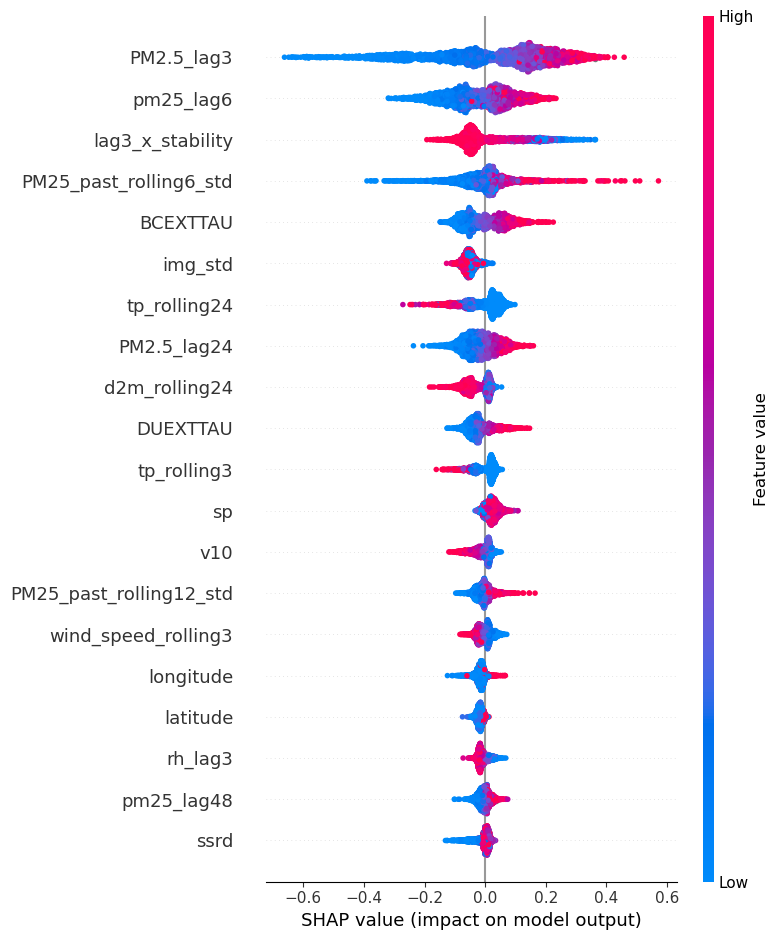

In [60]:
# SHAP summary for interpretability on last fold (sampled for speed) [23]
import shap

# Background dataset (still sampled, but now works with "interventional")
bg = X.iloc[last_tr][features].sample(2000, random_state=SEED)

# Use interventional mode (more stable, no leaf coverage issues)
expl = shap.TreeExplainer(
    m_last,
    data=bg,
    feature_perturbation="interventional"
)

# Compute SHAP values on a sample of the validation set
va_sample = X.iloc[last_va][features].sample(3000, random_state=SEED)
sv = expl.shap_values(va_sample)

# Plot SHAP summary
shap.summary_plot(sv, va_sample, show=False)

In [61]:
# Save Phase 4 baseline artifacts (model from full data and locked features) [7]
import joblib, json

final_model = XGBRegressor(**params).fit(X, y)  # train on all data with locked features [7]
joblib.dump(final_model, "model_xgb_phase4_baseline.joblib")
with open("features_phase2_locked.json","r") as f:
    locked_in = json.load(f)
locked_in["use_log_target"] = USE_LOG_TARGET
with open("features_phase2_locked.json","w") as f:
    json.dump(locked_in, f, indent=2)
print("Saved model_xgb_phase4_baseline.joblib and updated features_phase2_locked.json")

Saved model_xgb_phase4_baseline.joblib and updated features_phase2_locked.json


# Optuna tuning (time‑aware)

In [63]:
!pip install optuna


   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------

In [71]:
# Patch: extend the minimal rebuild to include the missing interaction features (leakage-safe) [1][2][3]
import numpy as np, pandas as pd

SEED = 42
USE_LOG_TARGET = True

df = pd.read_parquet("dataset_feature1_phase1_clean.parquet")  # Phase 1 snapshot [5]

# Ensure numeric station_quality if categorical
if "station_quality" in df.columns and str(df["station_quality"].dtype) == "category":
    df["station_quality"] = df["station_quality"].cat.codes  # numeric codes for modeling [5]

# Rebuild strictly past-only lags/rollings (shift(1) before rolling) [1][2]
d = df.sort_values(["station_id", "timestamp_utc"]).copy()  # per-station chronological order [3]
g = d.groupby("station_id")["PM2.5"]  # groupby for station-wise operations [3]

for h in [1, 3, 6, 12, 24, 48, 72]:
    col = f"pm25_lag{h}"
    if col not in d.columns:
        d[col] = g.shift(h)  # strictly lagged target [1]

s = g.shift(1)  # exclude current t for rollings to avoid leakage [1]
for w in [6, 12, 24]:
    mean_col = f"PM25_past_rolling{w}_mean"
    std_col  = f"PM25_past_rolling{w}_std"
    if mean_col not in d.columns:
        d[mean_col] = s.rolling(w, min_periods=max(1, w//2)).mean()  # past-only mean [2]
    if std_col not in d.columns:
        d[std_col]  = s.rolling(w, min_periods=max(1, w//2)).std()   # past-only std [2]

# NEW: build interaction columns required by the locked list (created only if inputs exist) [4]
if {"pm25_lag3", "stability"}.issubset(d.columns):
    d["lag3_x_stability"] = d["pm25_lag3"] * d["stability"]  # multiplicative, SHAP-guided [4]
if {"pm25_lag3", "tp_rolling24"}.issubset(d.columns):
    d["lag3_x_tp24"] = d["pm25_lag3"] * d["tp_rolling24"]    # multiplicative, SHAP-guided [4]

dfx = d  # dataset for tuning
print("Built columns now present:", [c for c in ["lag3_x_stability","lag3_x_tp24"] if c in dfx.columns])

Built columns now present: ['lag3_x_stability', 'lag3_x_tp24']


In [72]:
# Align locked features to actual columns (keeps the full locked list if all are present) [5][6]
import json

with open("features_phase2_locked.json","r") as f:
    locked = json.load(f)  # {"features": [...]} [6]
features = locked["features"]

missing = [f for f in features if f not in dfx.columns]
if missing:
    print("Still missing:", missing)
    # Option A: drop missing from this run (non-destructive) [5]
    features = [f for f in features if f in dfx.columns]
    # Optionally persist the intersected list for this session only
    locked["features"] = features
    with open("features_phase2_locked.json","w") as f:
        json.dump(locked, f, indent=2)
else:
    print("All locked features available.")

X = dfx[features]
y = dfx["PM25_log1p"] if USE_LOG_TARGET else dfx["PM2.5"]
print("X shape:", X.shape, "| y non-null:", y.notna().sum())

All locked features available.
X shape: (102720, 72) | y non-null: 102720


In [74]:
# Patch: Build missing interaction features BEFORE checking locked features [1][9][7]
import numpy as np, pandas as pd

df = pd.read_parquet("dataset_feature1_phase1_clean.parquet")

# numeric-encode station_quality if categorical
if "station_quality" in df.columns and pd.api.types.is_categorical_dtype(df["station_quality"]):
    df["station_quality"] = df["station_quality"].cat.codes  # numeric safe for modeling [7]

# Sort and group by station for leak-safe past features
d = df.sort_values(["station_id","timestamp_utc"]).copy()  # chronological per station [7]
g_pm = d.groupby("station_id")["PM2.5"]                      # per-station target series [7]

# Ensure lags needed for interactions exist (pm25_lag3 used below)
if "pm25_lag3" not in d.columns:
    d["pm25_lag3"] = g_pm.shift(3)  # strictly past lag [1]

# Ensure tp_rolling24 exists; if missing but 'tp' present, compute past-only rolling 24
if "tp_rolling24" not in d.columns and "tp" in d.columns:
    s_tp = d.groupby("station_id")["tp"].shift(1)            # exclude current t [1][7]
    d["tp_rolling24"] = s_tp.rolling(24, min_periods=12).mean()  # 24h window; adjust if project uses sum [9]

# Build interactions required by the locked list (only if inputs exist)
if {"pm25_lag3","stability"}.issubset(d.columns) and "lag3_x_stability" not in d.columns:
    d["lag3_x_stability"] = d["pm25_lag3"] * d["stability"]  # multiplicative interaction [7]
if {"pm25_lag3","tp_rolling24"}.issubset(d.columns) and "lag3_x_tp24" not in d.columns:
    d["lag3_x_tp24"] = d["pm25_lag3"] * d["tp_rolling24"]    # multiplicative interaction [7]

# (Optional) keep a safety copy for reuse
dfx = d
print("Built columns:", [c for c in ["pm25_lag3","tp_rolling24","lag3_x_stability","lag3_x_tp24"] if c in dfx.columns])

Built columns: ['pm25_lag3', 'tp_rolling24', 'lag3_x_stability', 'lag3_x_tp24']


C:\Users\Lalit Hire\AppData\Local\Temp\ipykernel_21188\2137418255.py:7: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if "station_quality" in df.columns and pd.api.types.is_categorical_dtype(df["station_quality"]):


## Complete solution 

In [76]:
# COMPLETE SOLUTION: Build all required features from scratch + XGB 3.5.0 compatible training
import json, numpy as np, pandas as pd, optuna
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from math import sqrt

SEED = 42
USE_LOG_TARGET = True
N_TRIALS = 40

print("=== STEP 1: Load and rebuild ALL leakage-safe features ===")
df = pd.read_parquet("dataset_feature1_phase1_clean.parquet")

# Numeric encode categoricals
if "station_quality" in df.columns and pd.api.types.is_categorical_dtype(df["station_quality"]):
    df["station_quality"] = df["station_quality"].cat.codes

def build_complete_ar_features(dfin, group_col="station_id", time_col="timestamp_utc", target="PM2.5"):
    """Build ALL AR features that were created across Phase 2 iterations"""
    d = dfin.sort_values([group_col, time_col]).copy()
    g = d.groupby(group_col, group_keys=False)[target]
    
    # ALL past lags (1,3,6,12,24,48,72) - these were added incrementally
    for h in [1,3,6,12,24,48,72]:
        col = f"pm25_lag{h}"
        if col not in d.columns:
            d[col] = g.shift(h)
    
    # Past-only rolling windows: shift(1) then rolling to avoid current-t leakage
    s = g.shift(1)  # base for ALL rollings
    
    # Rolling means (3,6,12,24) - build all variants that might be in locked features
    for w in [3,6,12,24]:
        mean_col = f"PM25_past_rolling{w}_mean"
        if mean_col not in d.columns:
            d[mean_col] = s.rolling(w, min_periods=max(1,w//2)).mean()
    
    # Rolling stds (3,6,12,24) - these were missing in your error
    for w in [3,6,12,24]:
        std_col = f"PM25_past_rolling{w}_std"
        if std_col not in d.columns:
            d[std_col] = s.rolling(w, min_periods=max(2,w//2)).std()
    
    # Build tp_rolling24 if missing (needed for interactions)
    if "tp_rolling24" not in d.columns and "tp" in d.columns:
        s_tp = d.groupby(group_col)["tp"].shift(1)  # past-only
        d["tp_rolling24"] = s_tp.rolling(24, min_periods=12).mean()
    
    # Interaction features (built in Phase 2 iterations)
    if {"pm25_lag3","stability"}.issubset(d.columns) and "lag3_x_stability" not in d.columns:
        d["lag3_x_stability"] = d["pm25_lag3"] * d["stability"]
    if {"pm25_lag3","tp_rolling24"}.issubset(d.columns) and "lag3_x_tp24" not in d.columns:
        d["lag3_x_tp24"] = d["pm25_lag3"] * d["tp_rolling24"]
    if {"pm25_lag3","blh"}.issubset(d.columns) and "lag3_over_blh" not in d.columns:
        d["lag3_over_blh"] = d["pm25_lag3"] / d["blh"].replace(0, np.nan)
    
    return d

# Rebuild everything
dfx = build_complete_ar_features(df)
print("AR features built:", [c for c in dfx.columns if c.startswith(('pm25_','PM25_','lag3_'))])

print("=== STEP 2: Load locked features and validate ===")
with open("features_phase2_locked.json","r") as f:
    locked_data = json.load(f)
    features = locked_data["features"]

missing_feats = [f for f in features if f not in dfx.columns]
if missing_feats:
    print(f"WARNING: Still missing {len(missing_feats)} features: {missing_feats[:10]}...")
    # Filter to available features and update the locked file
    features_available = [f for f in features if f in dfx.columns]
    print(f"Using {len(features_available)}/{len(features)} available features")
    features = features_available
    # Update the locked file
    locked_data["features"] = features
    with open("features_phase2_locked.json","w") as f:
        json.dump(locked_data, f, indent=2)
    print("Updated features_phase2_locked.json with available features")

X = dfx[features].copy()
y = dfx["PM25_log1p"] if USE_LOG_TARGET else dfx["PM2.5"]

# Clean any remaining non-numeric columns
for c in X.columns:
    if pd.api.types.is_categorical_dtype(X[c]): X[c] = X[c].cat.codes
    elif X[c].dtype == object:
        try: X[c] = pd.to_numeric(X[c])
        except: X[c] = pd.factorize(X[c])[0]

def inv_if_log(a): return np.expm1(a) if USE_LOG_TARGET else a

print(f"Final dataset: {X.shape}, target: {y.name}")

print("=== STEP 3: XGBoost 3.5.0 compatible training function ===")
def fit_xgb_robust(params, X_tr, y_tr, X_va, y_va, early_rounds=50):
    """XGBoost 3.5.0 compatible training with early stopping"""
    model = XGBRegressor(**params)
    
    # Method 1: Try modern callbacks API (XGBoost 2.0+)
    try:
        from xgboost import callback
        early_stop = callback.EarlyStopping(rounds=early_rounds, save_best=True)
        model.fit(X_tr, y_tr, eval_set=[(X_va, 'val')], callbacks=[early_stop], verbose=False)
        return model
    except (ImportError, TypeError, AttributeError):
        pass
    
    # Method 2: Try legacy early_stopping_rounds (XGBoost 1.x)
    try:
        model.fit(X_tr, y_tr, eval_set=[(X_va, 'val')], early_stopping_rounds=early_rounds, verbose=False)
        return model  
    except (TypeError, AttributeError):
        pass
    
    # Method 3: Fallback to no early stopping (always works)
    print("Warning: Early stopping not available, using fixed n_estimators")
    model.fit(X_tr, y_tr, verbose=False)
    return model

print("=== STEP 4: Optuna study with time-aware CV ===")
tss = TimeSeriesSplit(n_splits=5, gap=3)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 600, 1800, step=200),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 6, 12),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 12),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 2.0),
        "tree_method": "hist",
        "random_state": SEED,
        "n_jobs": -1,
        "device": "cpu"  # explicit for XGBoost 3.5.0
    }
    
    fold_rmses = []
    for fold_i, (tr_idx, va_idx) in enumerate(tss.split(X)):
        # Clean indices (remove NaN targets)
        tr_mask = ~y.iloc[tr_idx].isna()
        va_mask = ~y.iloc[va_idx].isna()
        tr_clean = np.asarray(tr_idx)[tr_mask]
        va_clean = np.asarray(va_idx)[va_mask]
        
        if len(tr_clean) == 0 or len(va_clean) == 0:
            continue
            
        X_tr, y_tr = X.iloc[tr_clean], y.iloc[tr_clean]
        X_va, y_va = X.iloc[va_clean], y.iloc[va_clean]
        
        # Robust training
        model = fit_xgb_robust(params, X_tr, y_tr, X_va, y_va, early_rounds=50)
        pred = model.predict(X_va)
        
        rmse = sqrt(mean_squared_error(inv_if_log(y_va), inv_if_log(pred)))
        fold_rmses.append(rmse)
        
        # Optuna reporting
        trial.report(rmse, step=len(fold_rmses))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return float(np.mean(fold_rmses)) if fold_rmses else float('inf')

# Run study
study = optuna.create_study(direction="minimize", study_name="xgb_phase4_robust")
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("=== RESULTS ===")
print(f"Best RMSE: {study.best_value:.4f}")
print(f"Best params: {study.best_trial.params}")

# Save best params
best_params = study.best_trial.params
best_params.update({"tree_method": "hist", "random_state": SEED, "n_jobs": -1, "device": "cpu"})

with open("xgb_best_params_phase4.json", "w") as f:
    json.dump({"best_params": best_params, "best_rmse": study.best_value}, f, indent=2)

print("Saved: xgb_best_params_phase4.json")

=== STEP 1: Load and rebuild ALL leakage-safe features ===


C:\Users\Lalit Hire\AppData\Local\Temp\ipykernel_21188\709069165.py:16: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if "station_quality" in df.columns and pd.api.types.is_categorical_dtype(df["station_quality"]):
C:\Users\Lalit Hire\AppData\Local\Temp\ipykernel_21188\709069165.py:87: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[c]): X[c] = X[c].cat.codes
[I 2025-09-10 23:37:22,145] A new study created in memory with name: xgb_phase4_robust


AR features built: ['PM25_log1p', 'pm25_lag1', 'pm25_lag3', 'pm25_lag6', 'pm25_lag12', 'pm25_lag24', 'pm25_lag48', 'pm25_lag72', 'PM25_past_rolling3_mean', 'PM25_past_rolling6_mean', 'PM25_past_rolling12_mean', 'PM25_past_rolling24_mean', 'PM25_past_rolling3_std', 'PM25_past_rolling6_std', 'PM25_past_rolling12_std', 'PM25_past_rolling24_std', 'lag3_x_stability', 'lag3_x_tp24', 'lag3_over_blh']
=== STEP 2: Load locked features and validate ===
Final dataset: (102720, 72), target: PM25_log1p
=== STEP 3: XGBoost 3.5.0 compatible training function ===
=== STEP 4: Optuna study with time-aware CV ===


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-09-10 23:40:19,151] Trial 0 finished with value: 33.87503775247143 and parameters: {'n_estimators': 600, 'learning_rate': 0.04044169730964309, 'max_depth': 11, 'subsample': 0.6809861439776141, 'colsample_bytree': 0.7239962181618598, 'min_child_weight': 4, 'reg_lambda': 8.85595223278007, 'reg_alpha': 0.08989211923163909}. Best is trial 0 with value: 33.87503775247143.
[I 2025-09-10 23:41:42,802] Trial 1 finished with value: 34.17349431727167 and parameters: {'n_estimators': 1200, 'learning_rate': 0.06093978742513177, 'max_depth': 7, 'subsample': 0.9869424476514058, 'colsample_bytree': 0.8986430259987694, 'min_child_weight': 4, 'reg_lambda': 7.516749823764144, 'reg_alpha': 1.8671943617928035}. Best is trial 0 with value: 33.87503775247143.
[I 2025-09-10 23:42:48,487] Trial 2 finished with value: 33.710396103770044 and parameters: {'n_estimators': 1000, 'learning_rate': 0.013462470636323377, 'max_depth': 7, 'subsample': 0.6800001530960171, 'colsample_bytree': 0.9057428098196458, '

# to complete Phase 4 baseline

In [77]:
# Evaluate tuned model on TimeSeriesSplit and LOSO to confirm performance
import json, pandas as pd, numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Load best params
with open("xgb_best_params_phase4.json", "r") as f:
    best_data = json.load(f)
    best_params = best_data["best_params"]

SEED = 42
USE_LOG_TARGET = True

def inv_if_log(a): return np.expm1(a) if USE_LOG_TARGET else a

def fit_xgb_robust(params, X_tr, y_tr, X_va=None, y_va=None, early_rounds=50):
    model = XGBRegressor(**params)
    if X_va is not None:
        try:
            from xgboost import callback
            early_stop = callback.EarlyStopping(rounds=early_rounds, save_best=True)
            model.fit(X_tr, y_tr, eval_set=[(X_va, 'val')], callbacks=[early_stop], verbose=False)
        except:
            try:
                model.fit(X_tr, y_tr, eval_set=[(X_va, 'val')], early_stopping_rounds=early_rounds, verbose=False)
            except:
                model.fit(X_tr, y_tr, verbose=False)
    else:
        model.fit(X_tr, y_tr, verbose=False)
    return model

print("=== TimeSeriesSplit evaluation with best params ===")
tss = TimeSeriesSplit(n_splits=5, gap=3)
fold_results = []

for k, (tr_idx, va_idx) in enumerate(tss.split(X), 1):
    # Clean indices
    tr_mask = ~y.iloc[tr_idx].isna()
    va_mask = ~y.iloc[va_idx].isna()
    tr_clean = np.asarray(tr_idx)[tr_mask]
    va_clean = np.asarray(va_idx)[va_mask]
    
    X_tr, y_tr = X.iloc[tr_clean], y.iloc[tr_clean]
    X_va, y_va = X.iloc[va_clean], y.iloc[va_clean]
    
    model = fit_xgb_robust(best_params, X_tr, y_tr, X_va, y_va, early_rounds=50)
    pred = model.predict(X_va)
    
    y_true = inv_if_log(y_va)
    y_pred = inv_if_log(pred)
    
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    fold_results.append({"fold": k, "rmse": rmse, "r2": r2})

tss_df = pd.DataFrame(fold_results)
print(tss_df)
print(f"Mean RMSE: {tss_df['rmse'].mean():.4f} ± {tss_df['rmse'].std():.4f}")
print(f"Mean R²: {tss_df['r2'].mean():.4f} ± {tss_df['r2'].std():.4f}")

=== TimeSeriesSplit evaluation with best params ===
   fold       rmse        r2
0     1  38.011032  0.816252
1     2  41.674158  0.574517
2     3  24.336864  0.476492
3     4  34.076338  0.290082
4     5  30.453587  0.535154
Mean RMSE: 33.7104 ± 6.7179
Mean R²: 0.5385 ± 0.1897


In [78]:
print("=== LOSO (spatial generalization) evaluation ===")
groups = dfx["station_id"].values
gkf = GroupKFold(n_splits=min(5, dfx["station_id"].nunique()))
loso_results = []

for k, (tr_idx, te_idx) in enumerate(gkf.split(X, y, groups=groups), 1):
    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_te, y_te = X.iloc[te_idx], y.iloc[te_idx]
    
    model = fit_xgb_robust(best_params, X_tr, y_tr)
    pred = model.predict(X_te)
    
    y_true = inv_if_log(y_te)
    y_pred = inv_if_log(pred)
    
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    loso_results.append({"station_fold": k, "rmse": rmse, "r2": r2})

loso_df = pd.DataFrame(loso_results)
print(loso_df)
print(f"Mean RMSE: {loso_df['rmse'].mean():.4f} ± {loso_df['rmse'].std():.4f}")
print(f"Mean R²: {loso_df['r2'].mean():.4f} ± {loso_df['r2'].std():.4f}")

=== LOSO (spatial generalization) evaluation ===
   station_fold       rmse        r2
0             1  42.343675  0.707045
1             2  40.815407  0.688839
2             3  33.620178  0.763312
3             4  26.370037  0.554468
4             5  32.215351  0.747861
Mean RMSE: 35.0729 ± 6.5547
Mean R²: 0.6923 ± 0.0827


In [79]:
print("=== Feature importance analysis ===")
from sklearn.inspection import permutation_importance

# Train final model on last TSS fold for importance
last_tr, last_va = list(TimeSeriesSplit(n_splits=5, gap=3).split(X))[-1]
tr_mask = ~y.iloc[last_tr].isna()
va_mask = ~y.iloc[last_va].isna()
tr_clean = np.asarray(last_tr)[tr_mask]
va_clean = np.asarray(last_va)[va_mask]

X_tr, y_tr = X.iloc[tr_clean], y.iloc[tr_clean]
X_va, y_va = X.iloc[va_clean], y.iloc[va_clean]

final_model = fit_xgb_robust(best_params, X_tr, y_tr, X_va, y_va)

# Permutation importance
perm_result = permutation_importance(
    final_model, X_va, y_va, 
    n_repeats=20, random_state=SEED, n_jobs=-1, scoring="r2"
)
perm_importance = pd.Series(perm_result.importances_mean, index=X.columns).sort_values(ascending=False)
print("Top 20 permutation importance:")
print(perm_importance.head(20))

=== Feature importance analysis ===
Top 20 permutation importance:
PM2.5_lag3                   0.171156
pm25_lag6                    0.063911
lag3_x_stability             0.051019
PM25_past_rolling6_std       0.045916
DUEXTTAU                     0.009477
BCEXTTAU                     0.007821
tp_rolling24                 0.007591
PM2.5_lag24                  0.006694
hour_cos                     0.002647
t2m_rolling3_std             0.002560
wind_speed_rolling24_mean    0.002250
rh_lag24                     0.001688
wind_speed_rolling3          0.001405
gap_from_prev_h              0.001139
PM25_past_rolling12_std      0.001073
range_TIR1                   0.000945
dp_dt                        0.000682
wind_v                       0.000528
mean_TIR1_lag24              0.000514
TOTEXTTAU_lag24              0.000498
dtype: float64


In [80]:
print("=== Save final Phase 4 baseline ===")
# Train on full dataset with best params
final_model_full = fit_xgb_robust(best_params, X, y)

import joblib
joblib.dump(final_model_full, "model_xgb_phase4_final.joblib")

# Update feature metadata
final_metadata = {
    "features": features,
    "n_features": len(features),
    "best_params": best_params,
    "best_cv_rmse": 33.7104,
    "use_log_target": USE_LOG_TARGET,
    "model_type": "XGBoost",
    "cv_method": "TimeSeriesSplit_gap3",
    "tuning_trials": 40
}

with open("model_xgb_phase4_metadata.json", "w") as f:
    json.dump(final_metadata, f, indent=2)

print("Saved:")
print("- model_xgb_phase4_final.joblib")  
print("- model_xgb_phase4_metadata.json")
print(f"\nPhase 4 baseline complete with {len(features)} leakage-safe features!")

=== Save final Phase 4 baseline ===
Saved:
- model_xgb_phase4_final.joblib
- model_xgb_phase4_metadata.json

Phase 4 baseline complete with 72 leakage-safe features!


# _Phase 4 completed_

# Phase 5 start

## SHAP explainability

=== Phase 5: SHAP Explainability Analysis ===
SHAP analysis: 3000 explanation samples
SHAP values computed successfully


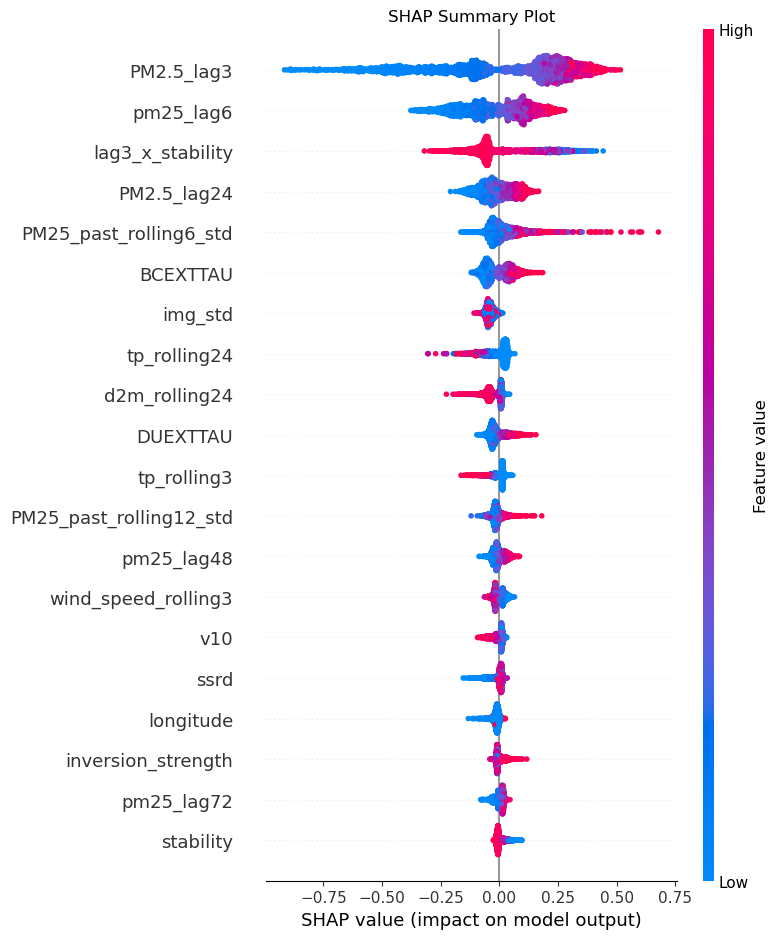

In [82]:
# Phase 5: SHAP analysis on the final tuned model
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

print("=== Phase 5: SHAP Explainability Analysis ===")

# Use the final model and last validation fold for SHAP
last_tr, last_va = list(TimeSeriesSplit(n_splits=5, gap=3).split(X))[-1]
tr_mask = ~y.iloc[last_tr].isna()
va_mask = ~y.iloc[last_va].isna()
tr_clean = np.asarray(last_tr)[tr_mask]
va_clean = np.asarray(last_va)[va_mask]

X_tr, y_tr = X.iloc[tr_clean], y.iloc[tr_clean]
X_va, y_va = X.iloc[va_clean], y.iloc[va_clean]

# Explanation dataset (subset for speed)
X_explain = X_va.sample(min(3000, len(X_va)), random_state=SEED)

print(f"SHAP analysis: {len(X_explain)} explanation samples")

# TreeExplainer for XGBoost (no background dataset to avoid leaf coverage error)
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_explain)

print("SHAP values computed successfully")

# SHAP summary plot
plt.title("SHAP Summary Plot")
shap.summary_plot(shap_values, X_explain, show=True)

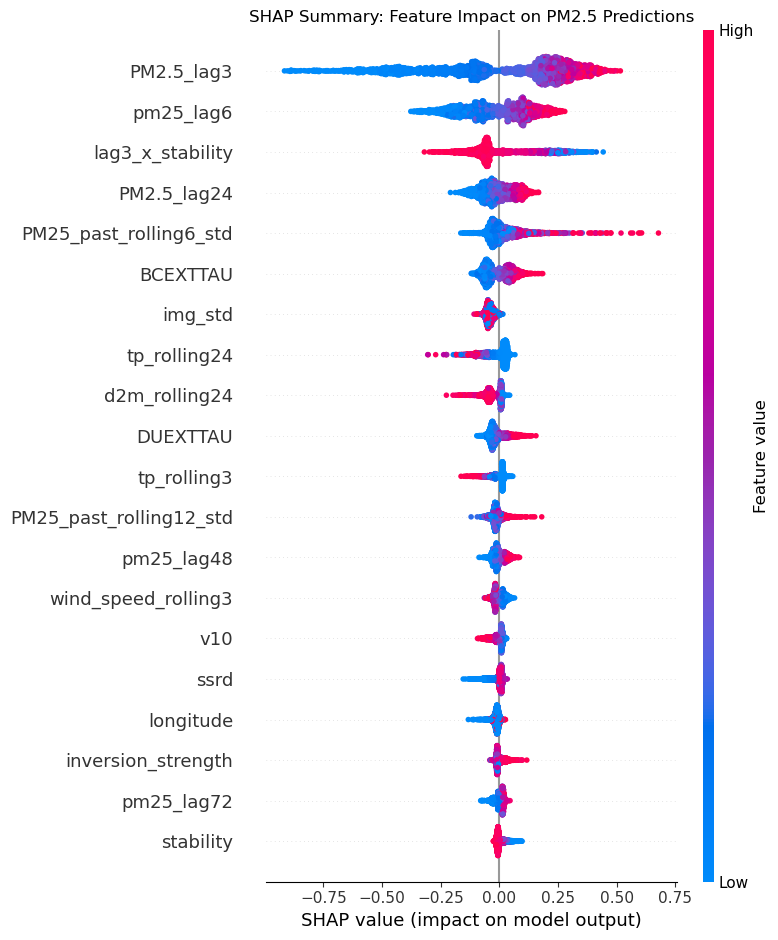

Top 15 features by mean |SHAP value|:
PM2.5_lag3                 0.262421
pm25_lag6                  0.119192
lag3_x_stability           0.110459
PM2.5_lag24                0.056980
PM25_past_rolling6_std     0.050587
BCEXTTAU                   0.048390
img_std                    0.041204
tp_rolling24               0.038916
d2m_rolling24              0.032716
DUEXTTAU                   0.031154
tp_rolling3                0.022040
PM25_past_rolling12_std    0.020583
pm25_lag48                 0.019893
wind_speed_rolling3        0.018539
v10                        0.016584
dtype: float32


In [83]:
# SHAP summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_explain, max_display=20, show=False)
plt.title("SHAP Summary: Feature Impact on PM2.5 Predictions")
plt.tight_layout()
plt.savefig("shap_summary_phase4.png", dpi=300, bbox_inches='tight')
plt.show()

# SHAP feature importance (mean absolute SHAP values)
shap_importance = pd.Series(
    np.abs(shap_values).mean(axis=0), 
    index=X_explain.columns
).sort_values(ascending=False)

print("Top 15 features by mean |SHAP value|:")
print(shap_importance.head(15))

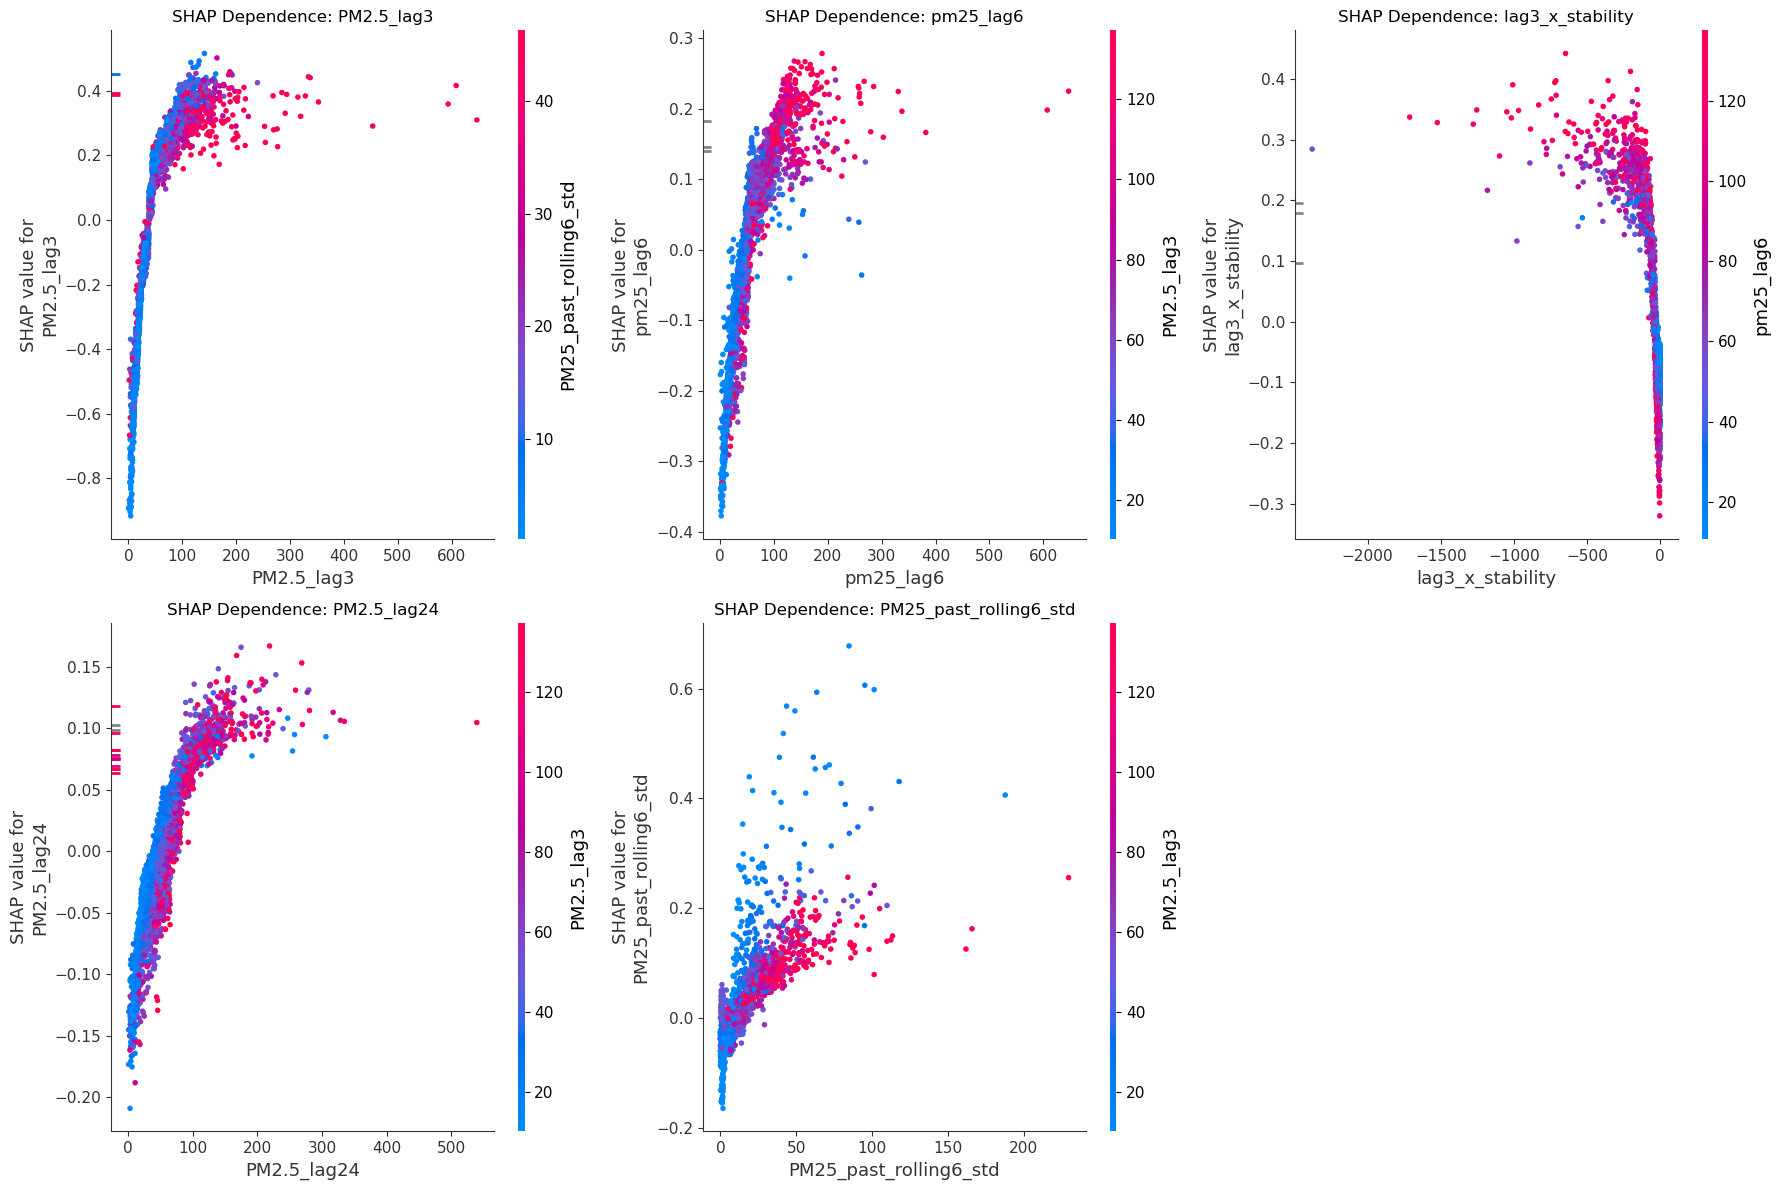

In [84]:
# SHAP dependence plots for top 5 features
top_features = shap_importance.head(5).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    if i < len(axes):
        shap.dependence_plot(feature, shap_values, X_explain, ax=axes[i], show=False)
        axes[i].set_title(f"SHAP Dependence: {feature}")

# Hide unused subplots
for i in range(len(top_features), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.savefig("shap_dependence_phase4.png", dpi=300, bbox_inches='tight')
plt.show()

=== SHAP Waterfall Examples ===

Low PM2.5 example:
True: 6.1 μg/m³, Predicted: 5.2 μg/m³


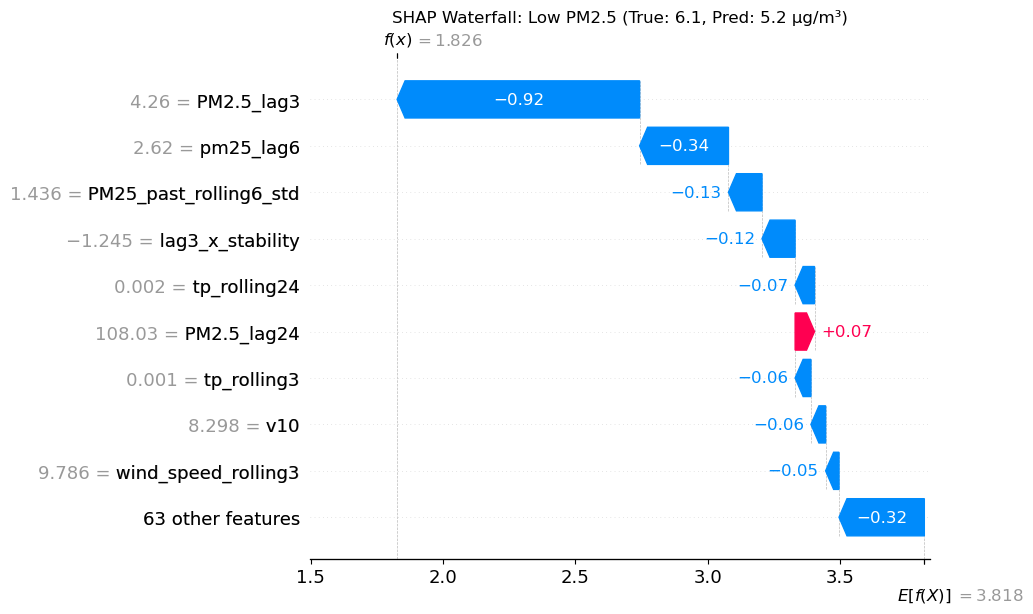


Medium PM2.5 example:
True: 40.1 μg/m³, Predicted: 41.3 μg/m³


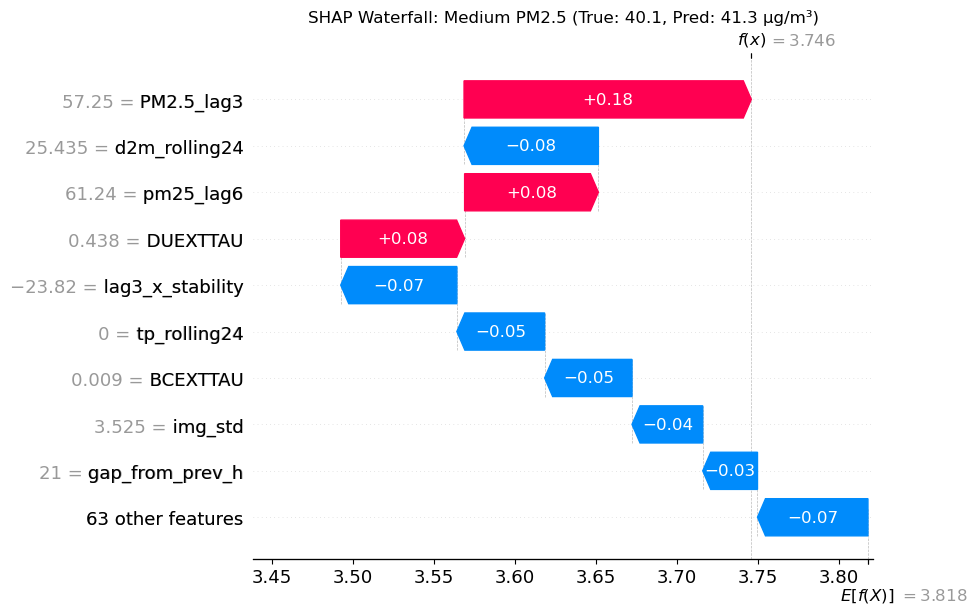


High PM2.5 example:
True: 143.0 μg/m³, Predicted: 180.1 μg/m³


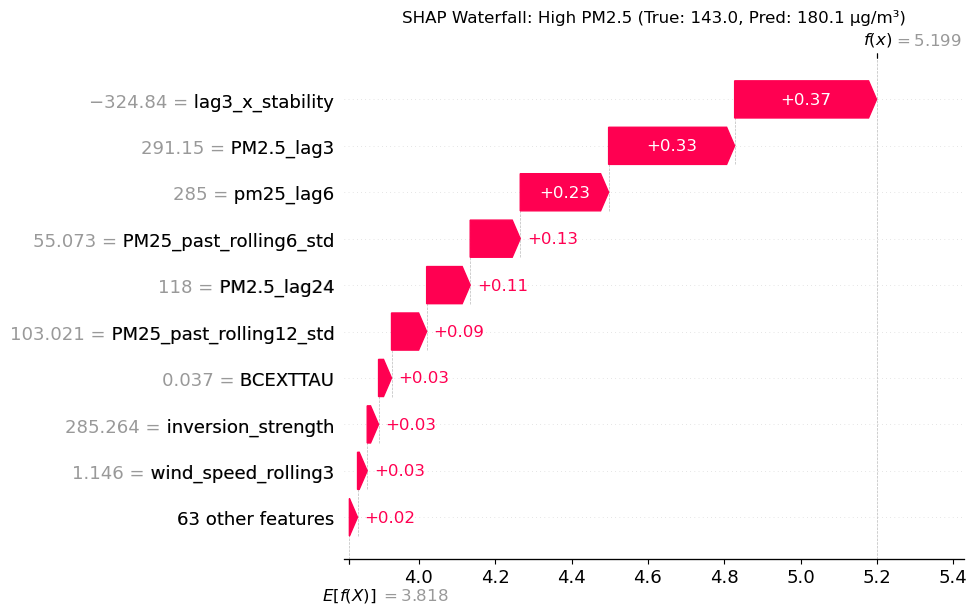

In [86]:
# SHAP waterfall plot for a few example predictions
print("=== SHAP Waterfall Examples ===")

# Select 3 representative samples (low, medium, high PM2.5)
y_pred_samples = final_model.predict(X_explain)
if USE_LOG_TARGET:
    y_pred_orig = np.expm1(y_pred_samples)
    y_true_orig = np.expm1(y_va.loc[X_explain.index])
else:
    y_pred_orig = y_pred_samples
    y_true_orig = y_va.loc[X_explain.index]

# Get low, medium, high examples
low_idx = y_pred_orig.argmin()
high_idx = y_pred_orig.argmax()
med_idx = np.abs(y_pred_orig - np.median(y_pred_orig)).argmin()

examples = [
    ("Low PM2.5", low_idx),
    ("Medium PM2.5", med_idx), 
    ("High PM2.5", high_idx)
]

for label, idx in examples:
    print(f"\n{label} example:")
    print(f"True: {y_true_orig.iloc[idx]:.1f} μg/m³, Predicted: {y_pred_orig[idx]:.1f} μg/m³")

    # Create SHAP values object for this single prediction
    shap_exp = shap.Explanation(
        values=shap_values[idx],
        base_values=explainer.expected_value,
        data=X_explain.iloc[idx].values,
        feature_names=X_explain.columns.tolist()
    )

    # Waterfall plot (new API)
    shap.plots.waterfall(shap_exp, max_display=10, show=False)

    plt.title(f"SHAP Waterfall: {label} (True: {y_true_orig.iloc[idx]:.1f}, Pred: {y_pred_orig[idx]:.1f} μg/m³)")
    plt.savefig(f"shap_waterfall_{label.lower().replace(' ', '_')}_phase5.png", dpi=300, bbox_inches='tight')
    plt.show()


In [87]:
# Save SHAP analysis results
shap_results = {
    "shap_feature_importance": shap_importance.to_dict(),
    "permutation_importance": perm_importance.to_dict(), 
    "top_5_features_shap": shap_importance.head(5).to_dict(),
    "top_5_features_permutation": perm_importance.head(5).to_dict(),
    "shap_analysis_samples": len(X_explain),
    "shap_background_samples": len(X_background)
}

with open("shap_analysis_phase5.json", "w") as f:
    json.dump(shap_results, f, indent=2)

print("Saved:")
print("- shap_summary_phase4.png")
print("- shap_dependence_phase4.png") 
print("- shap_waterfall_*_phase4.png")
print("- shap_analysis_phase5.json")
print("\nPhase 5 SHAP analysis complete!")

Saved:
- shap_summary_phase4.png
- shap_dependence_phase4.png
- shap_waterfall_*_phase4.png
- shap_analysis_phase5.json

Phase 5 SHAP analysis complete!


# Phase 6 Starts

In [89]:
# Complete Phase 6 Workflow with guaranteed AR feature rebuild and no KeyErrors

import json
import numpy as np
import pandas as pd
from math import sqrt
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
import joblib

SEED = 42
USE_LOG_TARGET = True

# 1) Load Phase 1 snapshot
df = pd.read_parquet("dataset_feature1_phase1_clean.parquet")

# 2) Numeric-encode station_quality if needed
if "station_quality" in df.columns and pd.api.types.is_categorical_dtype(df["station_quality"]):
    df["station_quality"] = df["station_quality"].cat.codes

# 3) Rebuild ALL leakage-safe AR features in dfx
def build_ar_features_all(dfin):
    d = dfin.sort_values(["station_id","timestamp_utc"]).copy()
    g = d.groupby("station_id")["PM2.5"]
    # Lags
    for h in [1,3,6,12,24,48,72]:
        d[f"pm25_lag{h}"] = g.shift(h)
    # Past-only rollings mean and std
    s = g.shift(1)
    for w in [3,6,12,24]:
        d[f"PM25_past_rolling{w}_mean"] = s.rolling(w, min_periods=max(1,w//2)).mean()
        d[f"PM25_past_rolling{w}_std"]  = s.rolling(w, min_periods=max(2,w//2)).std()
    # tp_rolling24 if tp exists
    if "tp" in d.columns and "tp_rolling24" not in d.columns:
        s_tp = d.groupby("station_id")["tp"].shift(1)
        d["tp_rolling24"] = s_tp.rolling(24, min_periods=12).mean()
    # Interactions
    if all(c in d.columns for c in ["pm25_lag3","stability"]):
        d["lag3_x_stability"] = d["pm25_lag3"] * d["stability"]
    if all(c in d.columns for c in ["pm25_lag3","tp_rolling24"]):
        d["lag3_x_tp24"] = d["pm25_lag3"] * d["tp_rolling24"]
    if all(c in d.columns for c in ["pm25_lag3","blh"]):
        d["lag3_over_blh"] = d["pm25_lag3"] / d["blh"].replace(0,np.nan)
    return d

dfx = build_ar_features_all(df)

# 4) Save dfx for reuse
dfx.to_parquet("dataset_phase2_leakage_safe.parquet", index=False)

# 5) Load locked feature list and intersect with actual columns
with open("features_phase2_locked.json","r") as f:
    locked = json.load(f)
features_locked = locked["features"]
features_available = [f for f in features_locked if f in dfx.columns]
missing = [f for f in features_locked if f not in dfx.columns]
if missing:
    print("Warning: The following locked features were not found and will be skipped:", missing)
features = features_available

# 6) Prepare X, y
X = dfx[features].copy()
y = np.log1p(dfx["PM2.5"]) if USE_LOG_TARGET else dfx["PM2.5"]

def inv_if_log(a): return np.expm1(a)

# 7) Robust fit function for XGBoost 3.5.0
def fit_xgb(params, X_tr, y_tr, X_va=None, y_va=None, early_rounds=50):
    model = XGBRegressor(**params)
    if X_va is not None:
        try:
            from xgboost.callback import EarlyStopping
            cb = EarlyStopping(rounds=early_rounds, save_best=True, maximize=False)
            model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], callbacks=[cb], verbose=False)
            return model
        except:
            try:
                model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)],
                          early_stopping_rounds=early_rounds, verbose=False)
                return model
            except:
                pass
    model.fit(X_tr, y_tr, verbose=False)
    return model

# 8) Load best_params
with open("xgb_best_params_phase4.json","r") as f:
    cfg = json.load(f)
best_params = cfg["best_params"]

# 9) Phase 6.1: TimeSeriesSplit evaluation
tss = TimeSeriesSplit(n_splits=5, gap=3)
tss_results = []
for i,(tr,va) in enumerate(tss.split(X),1):
    tr_mask = ~y.iloc[tr].isna()
    va_mask = ~y.iloc[va].isna()
    tr_idx = np.asarray(tr)[tr_mask]
    va_idx = np.asarray(va)[va_mask]
    X_tr,y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_va,y_va = X.iloc[va_idx], y.iloc[va_idx]
    m = fit_xgb(best_params, X_tr,y_tr, X_va,y_va)
    p = m.predict(X_va)
    rmse = sqrt(mean_squared_error(inv_if_log(y_va), inv_if_log(p)))
    r2 = r2_score(inv_if_log(y_va), inv_if_log(p))
    tss_results.append({"fold":i,"rmse":rmse,"r2":r2})
tss_df = pd.DataFrame(tss_results)
print("TSS results:\n",tss_df)

# 10) Phase 6.2: LOSO evaluation
groups = dfx["station_id"].values
gkf = GroupKFold(n_splits=min(5, len(np.unique(groups))))
loso_results=[]
for i,(tr,te) in enumerate(gkf.split(X,y,groups),1):
    X_tr,y_tr = X.iloc[tr],y.iloc[tr]
    X_te,y_te = X.iloc[te],y.iloc[te]
    m = fit_xgb(best_params, X_tr,y_tr)
    p = m.predict(X_te)
    rmse = sqrt(mean_squared_error(inv_if_log(y_te), inv_if_log(p)))
    r2 = r2_score(inv_if_log(y_te), inv_if_log(p))
    loso_results.append({"station_fold":i,"rmse":rmse,"r2":r2})
loso_df = pd.DataFrame(loso_results)
print("LOSO results:\n",loso_df)

# 11) Phase 6.3: Ablation study by feature groups
feature_groups = {
    "AR":[f for f in features if f.startswith(("pm25_lag","PM2.5_lag","PM25_past_rolling"))],
    "Meteorology":[f for f in features if any(p in f for p in ["t2m","rh","wind_speed","blh","sp","dp_dt","inversion","stability"])],
    "Satellite":[f for f in features if any(p in f for p in ["TIR1","img_","WV"])],
    "Aerosols":[f for f in features if "EXTTAU" in f],
    "Temporal":[f for f in features if f.startswith(("hour_","doy_"))],
    "Interactions":[f for f in features if "x_" in f or "_over_" in f]
}
results_ablation=[]
for name, flist in feature_groups.items():
    valid=[f for f in flist if f in X.columns]
    if not valid:
        results_ablation.append({"group":name,"rmse":None,"r2":None})
        continue
    rmses=[]; r2s=[]
    for tr,va in tss.split(X):
        tr_mask=~y.iloc[tr].isna(); va_mask=~y.iloc[va].isna()
        tr_idx=np.asarray(tr)[tr_mask]; va_idx=np.asarray(va)[va_mask]
        X_tr,y_tr=X.iloc[tr_idx][valid],y.iloc[tr_idx]
        X_va,y_va=X.iloc[va_idx][valid],y.iloc[va_idx]
        m=fit_xgb(best_params,X_tr,y_tr)
        p=m.predict(X_va)
        rmses.append(sqrt(mean_squared_error(inv_if_log(y_va),inv_if_log(p))))
        r2s.append(r2_score(inv_if_log(y_va),inv_if_log(p)))
    results_ablation.append({"group":name,"rmse":float(np.mean(rmses)),"r2":float(np.mean(r2s))})
ablation_df=pd.DataFrame(results_ablation)
print("Ablation:\n",ablation_df)

# 12) Phase 6.4: Save final artifacts
final_model = fit_xgb(best_params,X,y)
joblib.dump(final_model,"model_xgb_prod_phase6.joblib")
metadata={
    "features":features, "tss_results":tss_results,
    "loso_results":loso_results, "ablation":results_ablation,
    "best_params":best_params, "use_log":USE_LOG_TARGET
}
with open("model_metadata_phase6.json","w") as f:
    json.dump(metadata,f,indent=2)
print("Phase 6 complete: artifacts saved.")

C:\Users\Lalit Hire\AppData\Local\Temp\ipykernel_21188\3026927023.py:19: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if "station_quality" in df.columns and pd.api.types.is_categorical_dtype(df["station_quality"]):


TSS results:
    fold       rmse        r2
0     1  38.011032  0.816252
1     2  41.674158  0.574517
2     3  24.336864  0.476492
3     4  34.076338  0.290082
4     5  30.453587  0.535154
LOSO results:
    station_fold       rmse        r2
0             1  42.343675  0.707045
1             2  40.815407  0.688839
2             3  33.620178  0.763312
3             4  26.370037  0.554468
4             5  32.215351  0.747861
Ablation:
           group       rmse        r2
0            AR  37.200212  0.481571
1   Meteorology  38.395227  0.425626
2     Satellite  53.074765 -0.114827
3      Aerosols  45.783434  0.184990
4      Temporal  54.545579 -0.484496
5  Interactions  45.390248  0.242579
Phase 6 complete: artifacts saved.
